In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

successfully loaded {'experiment_name': 'fvt_training_higher_sr', 'n_sample_ratio': 1.0, 'signal_ratio': 0.01, 'seed': 42}


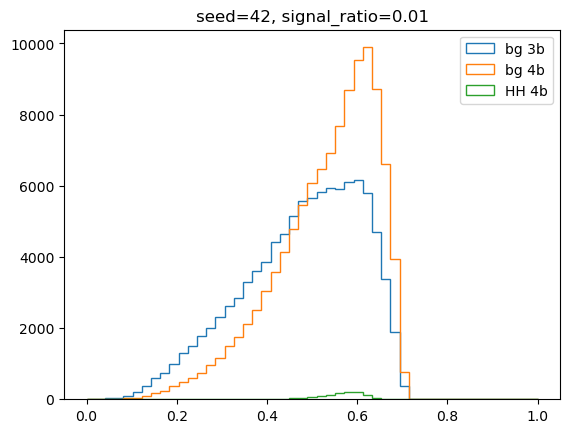

successfully loaded {'experiment_name': 'fvt_training_higher_sr', 'n_sample_ratio': 1.0, 'signal_ratio': 0.02, 'seed': 42}


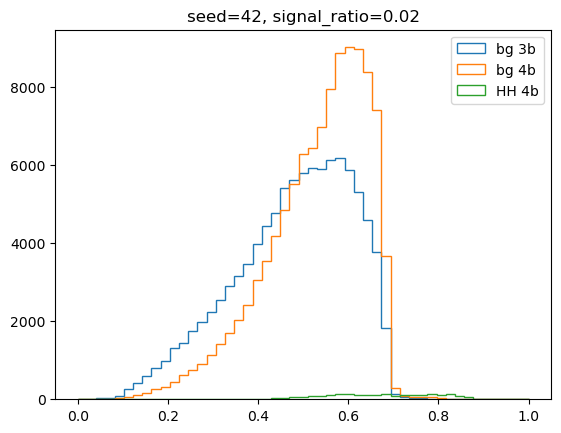

successfully loaded {'experiment_name': 'fvt_training_higher_sr', 'n_sample_ratio': 1.0, 'signal_ratio': 0.03, 'seed': 42}


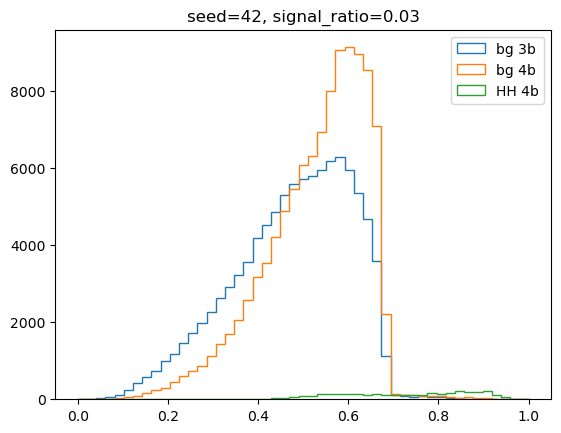

successfully loaded {'experiment_name': 'fvt_training_higher_sr', 'n_sample_ratio': 1.0, 'signal_ratio': 0.04, 'seed': 42}


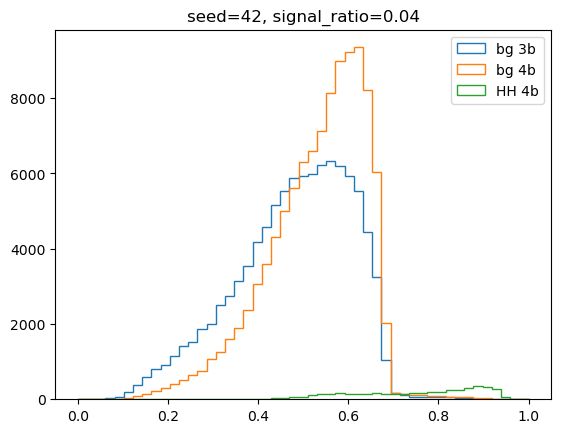

successfully loaded {'experiment_name': 'fvt_training_higher_sr', 'n_sample_ratio': 1.0, 'signal_ratio': 0.05, 'seed': 42}


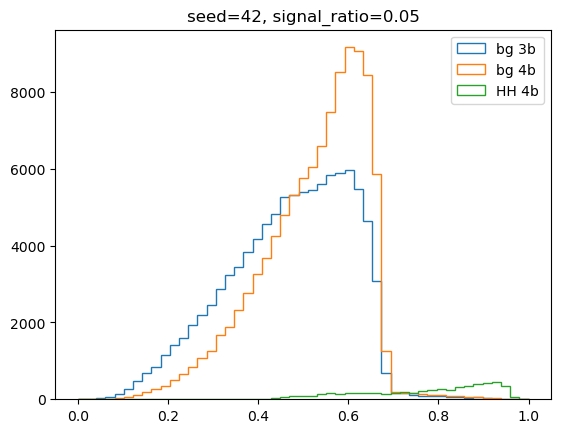

In [3]:
import torch
from dataset import generate_tt_dataset
from training_info import TrainingInfo
import pytorch_lightning as pl
import yaml
from fvt_classifier import FvTClassifier
from code_fragments import att_q_repr_hist, fvt_score_hist
from events_data import EventsData
import tqdm
import numpy as np
import matplotlib.pyplot as plt

config_filename = "configs/fvt_training_higher_sr.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
n_all4b = config["n_all4b"]
signal_ratio = config["signal_ratio"]
test_ratio = config["test_ratio"]
# n_sample_ratios = config["n_sample_ratios"]
n_sample_ratios = [1.0]
seeds = [42]
w_cuts = np.arange(0.01, 1.01, 0.01)
signal_ratios = [0.01, 0.02, 0.03, 0.04, 0.05]

fvt_scores_dict = {seed: {} for seed in seeds}
att_q_reprs_dict = {seed: {} for seed in seeds}
events_test_dict = {seed: {} for seed in seeds}
is_in_regions_list_dict = {seed: {} for seed in seeds}
embeddings_dict = {seed: {} for seed in seeds}

for seed in seeds:
    for signal_ratio in signal_ratios:
        _, dinfo_test = generate_tt_dataset(
                seed,
                n_3b,
                n_all4b,
                signal_ratio,
                test_ratio,
            )
        events_test = EventsData.from_dataframe(dinfo_test.fetch_data(), features)
        hparam_filter = {
            "experiment_name": experiment_name, 
            "n_sample_ratio": 1.0, 
            "signal_ratio": signal_ratio, 
            "seed": seed
        }
        hashes = TrainingInfo.find(hparam_filter)
        assert len(hashes) == 1
        print("successfully loaded", hparam_filter)
        hash = hashes[0]
        tinfo = TrainingInfo.load(hash)

        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        events_test.set_model_scores(fvt_model)
        
        events_test_dict[seed][signal_ratio] = events_test.clone()
        fvt_scores_dict[seed][signal_ratio] = events_test.fvt_score.copy()
        att_q_reprs_dict[seed][signal_ratio] = events_test.att_q_repr.copy()

        fig, ax = plt.subplots()
        bins_range = np.linspace(0, 1, 50)
        ax.set_title(f"seed={seed}, signal_ratio={signal_ratio}")
        ax.hist(fvt_scores_dict[seed][signal_ratio][events_test.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax.hist(fvt_scores_dict[seed][signal_ratio][events_test.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax.hist(fvt_scores_dict[seed][signal_ratio][events_test.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax.legend()

        plt.show()
        plt.close()

/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Elapsed time: 0.12 s
Elapsed time: 6.93 s
Elapsed time: 0.86 s


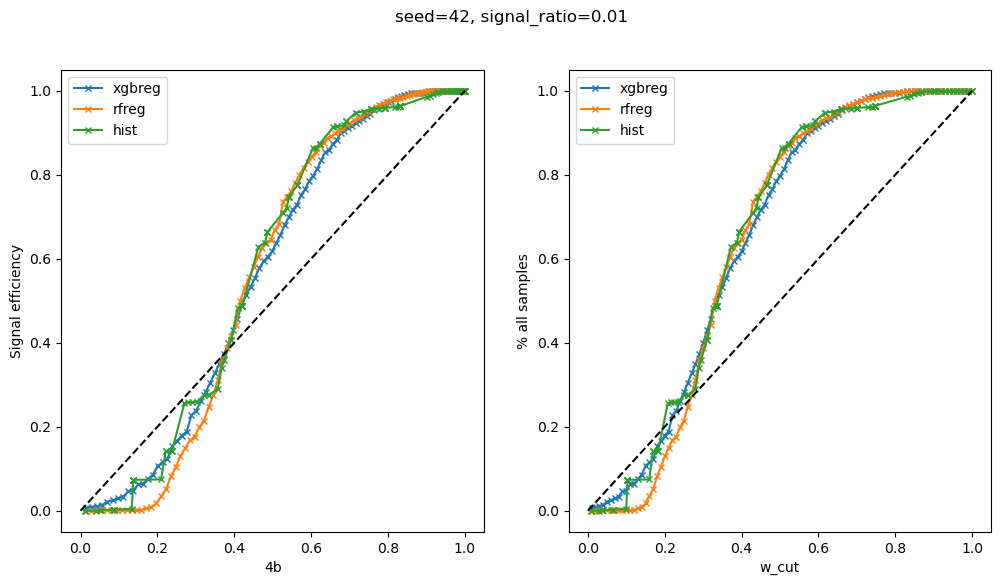

Elapsed time: 0.11 s
Elapsed time: 6.98 s
Elapsed time: 0.79 s


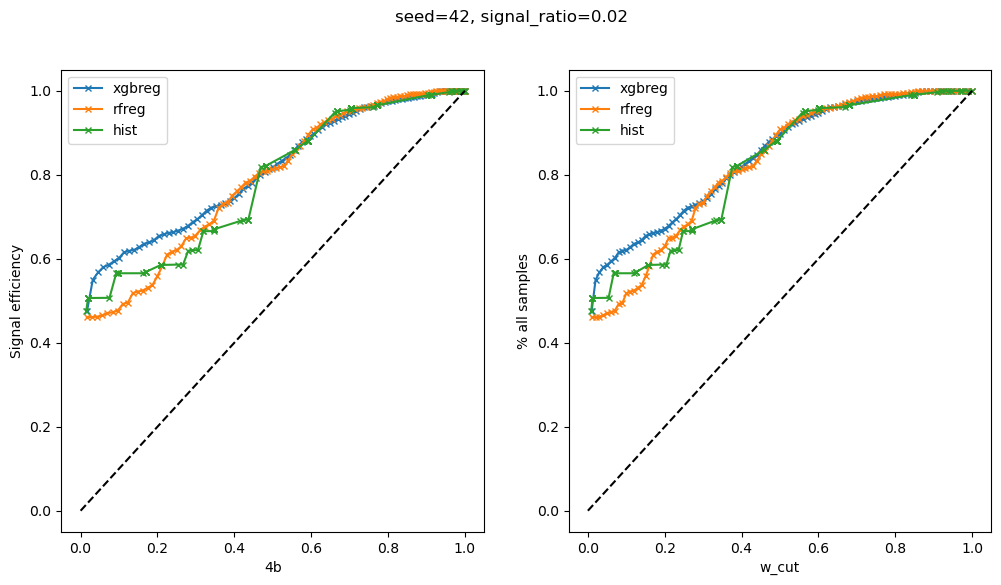

Elapsed time: 0.10 s
Elapsed time: 6.93 s
Elapsed time: 0.84 s


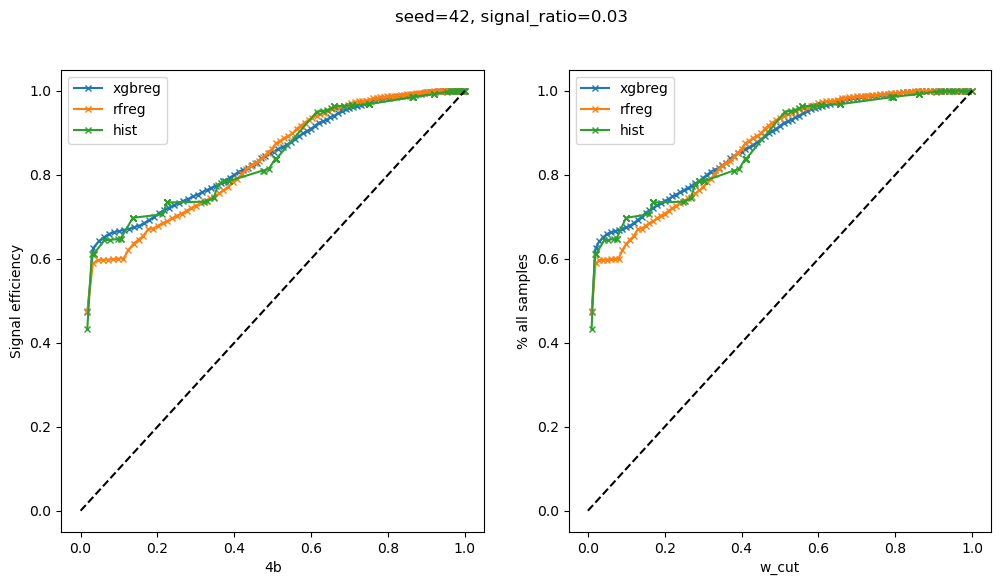

Elapsed time: 0.12 s
Elapsed time: 7.01 s
Elapsed time: 1.74 s


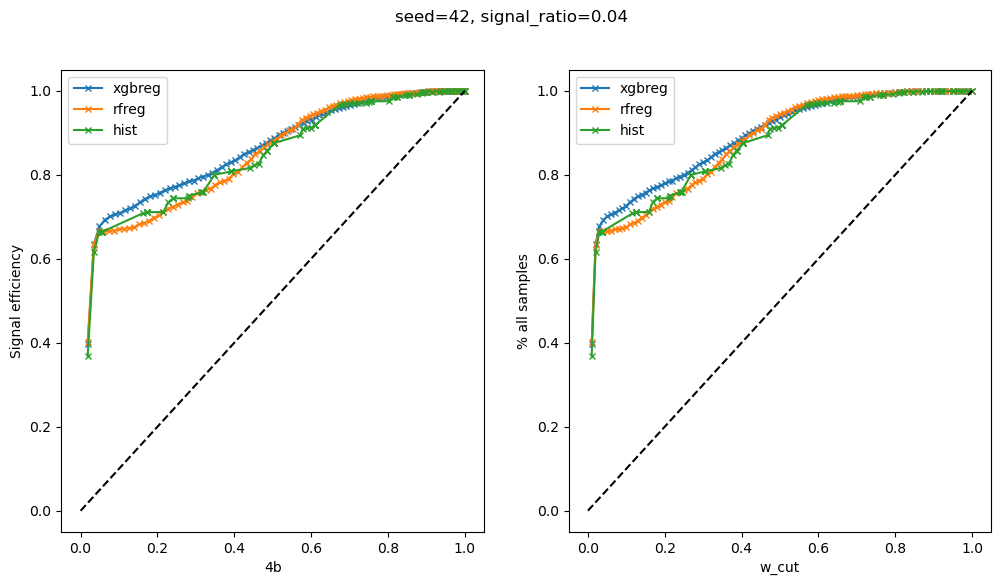

Elapsed time: 0.10 s
Elapsed time: 6.77 s
Elapsed time: 1.48 s


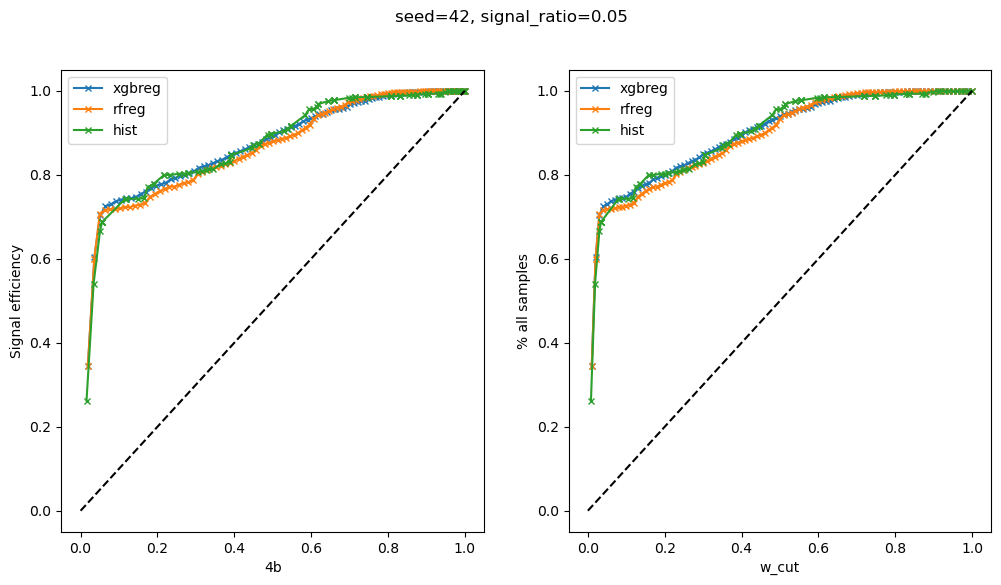

In [6]:
import time
from signal_region import get_regions_via_histogram, get_regions_via_probs_4b
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

using_features = [0, 1, 2, 3, 4, 5]
w_cuts = np.arange(0.01, 1.01, 0.01)

for seed in seeds:
    for signal_ratio in signal_ratios:
        events = events_test_dict[seed][signal_ratio]
        is_3b = events.is_3b
        is_bg4b = events.is_bg4b
        is_signal = events.is_signal
        is_4b = events.is_4b
        w = events.weights

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        fig.suptitle(f"seed={seed}, signal_ratio={signal_ratio}")

        att_q_repr = att_q_reprs_dict[seed][signal_ratio]

        for method in ["xgbreg", "rfreg", "hist"]:
            start_time = time.time()
            if method == "xgbreg":
                xgbreg = XGBRegressor(n_estimators=20, max_depth=5, random_state=seed)
                xgbreg.fit(att_q_repr, is_4b, sample_weight=w)
                probs_4b_estimated = xgbreg.predict(att_q_repr)
                is_in_regions_list = get_regions_via_probs_4b(events, w_cuts, probs_4b_estimated)
            elif method == "rfreg":
                rfreg = RandomForestRegressor(n_estimators=20, max_depth=5, random_state=seed)
                rfreg.fit(att_q_repr, is_4b, sample_weight=w)
                probs_4b_estimated = rfreg.predict(att_q_repr)
                is_in_regions_list = get_regions_via_probs_4b(events, w_cuts, probs_4b_estimated)
            elif method == "hist":
                is_in_regions_list = get_regions_via_histogram(events, w_cuts, n_bins=8)
            else:
                raise ValueError(f"Unknown method: {method}")

            print(f"Elapsed time: {time.time() - start_time:.2f} s")

            w_signal = np.array([np.sum(w[is_signal & is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w[is_signal])
            w_all = np.array([np.sum(w[is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w)
            w_4b = np.array([np.sum(w[is_4b & is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w[is_4b])

            ax[0].plot( 
                w_4b,
                w_signal,
                label=method,
                marker="x",
                markersize=4
            )
            ax[1].plot(
                w_all,
                w_signal,
                label=method,
                marker="x",
                markersize=4
            )

        ax[0].plot([0, 1], [0, 1], linestyle="--", color="black")
        ax[0].set_xlabel("4b")
        ax[0].set_ylabel("Signal efficiency")
        ax[0].legend()

        ax[1].plot([0, 1], [0, 1], linestyle="--", color="black")
        ax[1].set_xlabel("w_cut")
        ax[1].set_ylabel("% all samples")
        ax[1].legend()

        plt.show()
        plt.close()


In [7]:
# XGB hyparams tuning

import pandas as pd
from itertools import product
import cupy as cp

using_features = [0, 1, 2, 3, 4, 5]
w_cuts = np.arange(0.01, 1.01, 0.01)

max_depths = [2, 5, 10, 20]
n_estimators = [10, 20, 50, 100]

performance_dict = {(seed, signal_ratio): {} for seed in seeds for signal_ratio in signal_ratios}

for seed in seeds:
    for signal_ratio in signal_ratios:
        events = events_test_dict[seed][signal_ratio]
        is_3b = events.is_3b
        is_bg4b = events.is_bg4b
        is_signal = events.is_signal
        is_4b = events.is_4b
        w = events.weights

        hash = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed, "signal_ratio": signal_ratio, "n_sample_ratio": 1.0})[0]
        tinfo = TrainingInfo.load(hash)
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        events_sr_train, events_sr_test = events.split(0.5, seed=seed)
        events_sr_train.set_model_scores(fvt_model)
        events_sr_test.set_model_scores(fvt_model)

        att_q_repr = att_q_reprs_dict[seed][signal_ratio]
        X_train = cp.array(events_sr_train.att_q_repr)
        y_train = cp.array(events_sr_train.is_4b)
        w_train = cp.array(events_sr_train.weights)

        for n_estimator, max_depth in tqdm.tqdm(product(n_estimators, max_depths)):
            start_time = time.time()
            xgbreg = XGBRegressor(n_estimators=n_estimator, max_depth=max_depth, random_state=seed)
            xgbreg.fit(X_train, y_train, sample_weight=w_train)
            
            probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)
            is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)

            w_signal = np.array([np.sum(events_sr_test.weights[events_sr_test.is_signal & is_in_regions]) 
                                for is_in_regions in is_in_regions_list]) / np.sum(
                                    events_sr_test.weights[events_sr_test.is_signal])
            w_4b = np.array([np.sum(events_sr_test.weights[events_sr_test.is_4b & is_in_regions]) 
                                for is_in_regions in is_in_regions_list]) / np.sum(
                                    events_sr_test.weights[events_sr_test.is_4b])

            # calculate area under (w_4b, w_signal) curve

            auc = 0
            auc_w_4b_cut = 0.5
            for i in range(1, len(w_4b)):
                if w_4b[i] > auc_w_4b_cut:
                    continue
                auc += (min(w_4b[i], 0.5) - w_4b[i - 1]) * (w_signal[i] + w_signal[i - 1]) / 2

            performance_dict[(seed, signal_ratio)][(n_estimator, max_depth)] = auc
            
df = pd.DataFrame(performance_dict)

16it [00:07,  2.28it/s]
16it [00:06,  2.37it/s]
16it [00:06,  2.37it/s]
16it [00:07,  2.24it/s]
16it [00:07,  2.19it/s]


Best hparams: n_estimator=100, max_depth=5


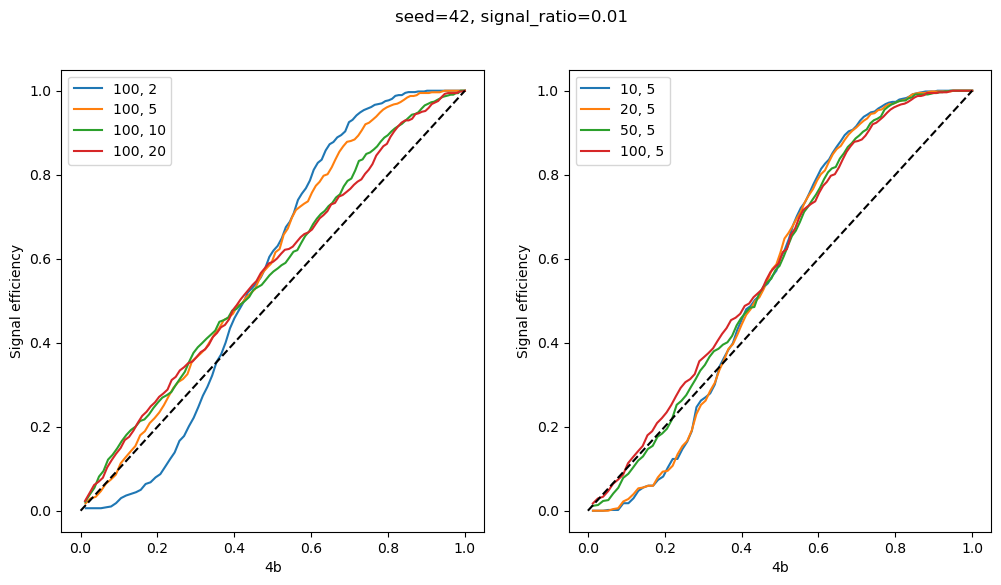

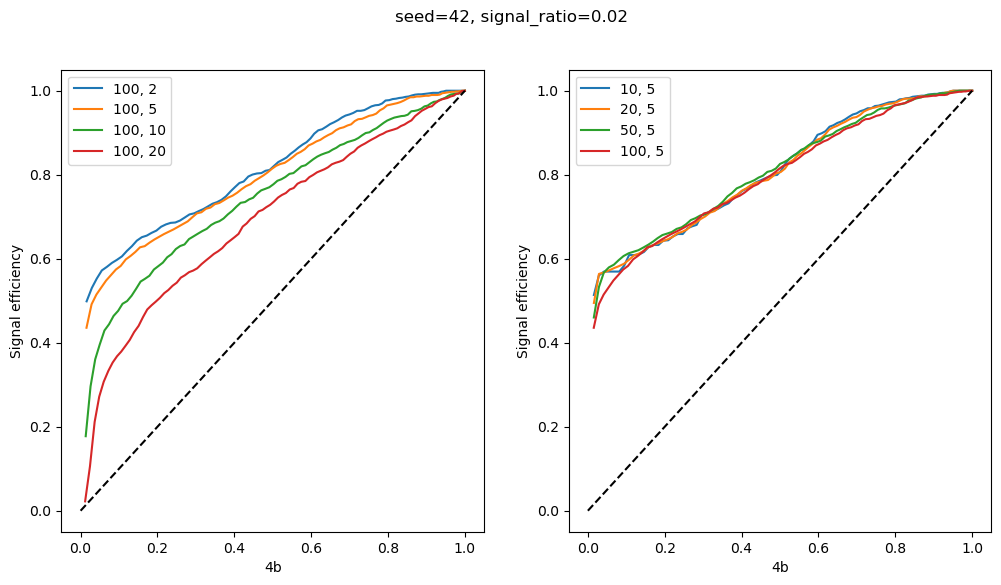

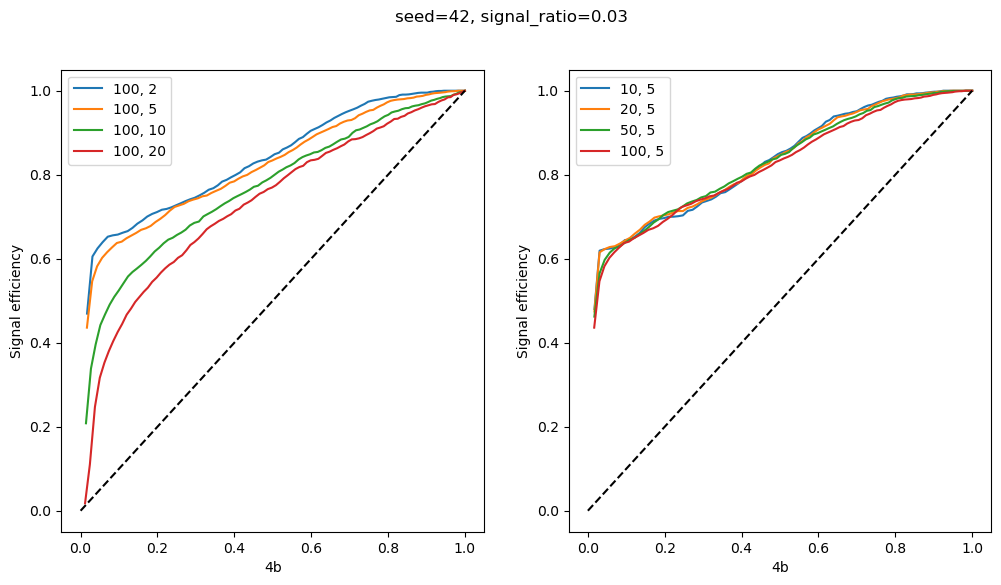

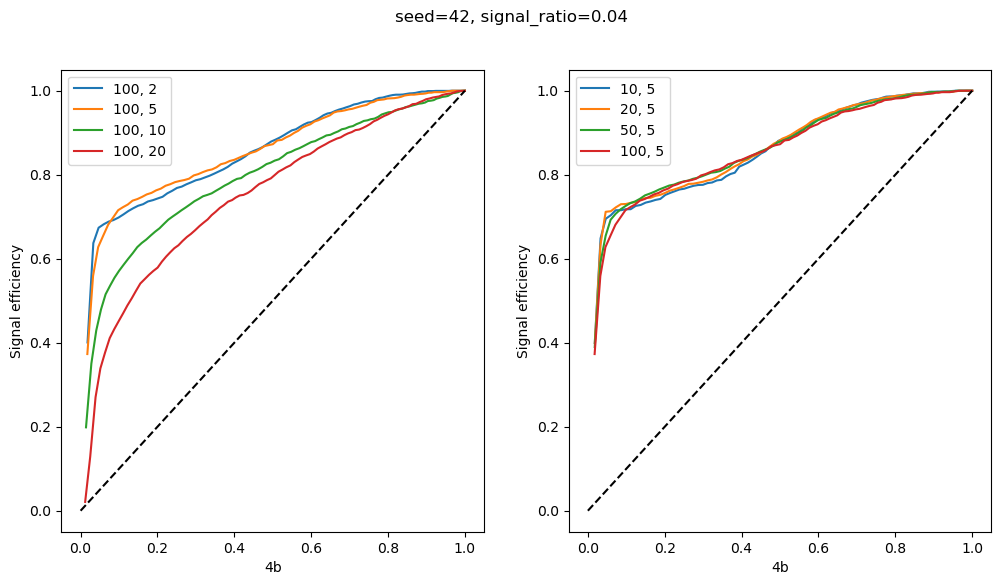

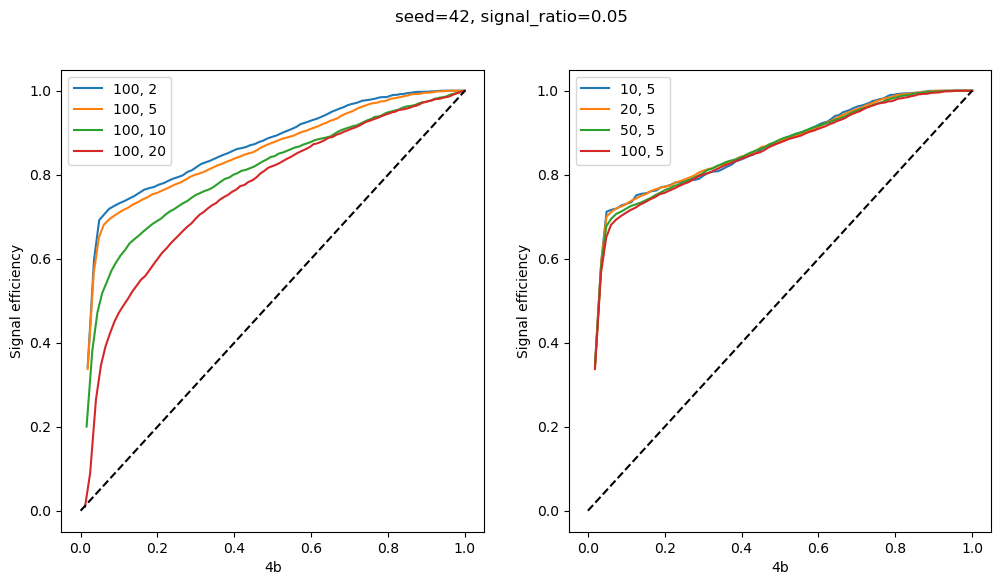

In [8]:
best_n_estimator, best_max_depth = df.T.describe().loc["mean"].idxmax()

print(f"Best hparams: n_estimator={best_n_estimator}, max_depth={best_max_depth}")
# plots for best params



for seed in seeds:
    for signal_ratio in signal_ratios:
        events = events_test_dict[seed][signal_ratio]
        is_3b = events.is_3b
        is_bg4b = events.is_bg4b
        is_signal = events.is_signal
        is_4b = events.is_4b
        w = events.weights

        hash = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed, 
                                  "signal_ratio": signal_ratio, "n_sample_ratio": 1.0})[0]
        tinfo = TrainingInfo.load(hash)
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        events_sr_train, events_sr_test = events.split(0.5, seed=seed)
        events_sr_train.set_model_scores(fvt_model)
        events_sr_test.set_model_scores(fvt_model)    

        fig, ax = plt.subplots()
        bins_range = np.linspace(0, 1, 50)
        ax.set_title(f"seed={seed}, signal_ratio={signal_ratio}")
        ax.hist(events_sr_test.fvt_score[events_sr_test.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax.hist(events_sr_test.fvt_score[events_sr_test.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax.hist(events_sr_test.fvt_score[events_sr_test.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax.legend()
        plt.show()
        plt.close()

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        fig.suptitle(f"seed={seed}, signal_ratio={signal_ratio}")

        att_q_repr = att_q_reprs_dict[seed][signal_ratio]
        X_train = cp.array(events_sr_train.att_q_repr)
        y_train = cp.array(events_sr_train.is_4b)
        w_train = cp.array(events_sr_train.weights)

        for max_depth in max_depths:
            xgbreg = XGBRegressor(n_estimators=best_n_estimator, max_depth=max_depth, random_state=seed)
            xgbreg.fit(X_train, y_train, sample_weight=w_train)

            probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)
            is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)

            w_signal = np.array([np.sum(events_sr_test.weights[events_sr_test.is_signal & is_in_regions]) 
                                for is_in_regions in is_in_regions_list]) / np.sum(
                                    events_sr_test.weights[events_sr_test.is_signal])
            w_4b = np.array([np.sum(events_sr_test.weights[events_sr_test.is_4b & is_in_regions]) 
                                for is_in_regions in is_in_regions_list]) / np.sum(
                                    events_sr_test.weights[events_sr_test.is_4b])
            w_all = np.array([np.sum(events_sr_test.weights[is_in_regions])
                                for is_in_regions in is_in_regions_list]) / np.sum(events_sr_test.weights)


            ax[0].plot( 
                w_4b,
                w_signal,
                label=f"{best_n_estimator}, {max_depth}",
            )

        ax[0].plot([0, 1], [0, 1], linestyle="--", color="black")
        ax[0].set_xlabel("4b")
        ax[0].set_ylabel("Signal efficiency")
        ax[0].legend()
        
        for n_estimator in n_estimators:
            xgbreg = XGBRegressor(n_estimators=n_estimator, max_depth=best_max_depth, random_state=seed)
            xgbreg.fit(X_train, y_train, sample_weight=w_train)

            probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)
            is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)

            w_signal = np.array([np.sum(events_sr_test.weights[events_sr_test.is_signal & is_in_regions]) 
                                for is_in_regions in is_in_regions_list]) / np.sum(
                                    events_sr_test.weights[events_sr_test.is_signal])
            w_4b = np.array([np.sum(events_sr_test.weights[events_sr_test.is_4b & is_in_regions])
                                    for is_in_regions in is_in_regions_list]) / np.sum(
                                        events_sr_test.weights[events_sr_test.is_4b])
            w_all = np.array([np.sum(events_sr_test.weights[is_in_regions])
                                for is_in_regions in is_in_regions_list]) / np.sum(events_sr_test.weights)


            ax[1].plot( 
                w_4b,
                w_signal,
                label=f"{n_estimator}, {best_max_depth}",
            )

        ax[1].plot([0, 1], [0, 1], linestyle="--", color="black")
        
        ax[1].set_xlabel("4b")
        ax[1].set_ylabel("Signal efficiency")
        ax[1].legend()

        plt.show()
        plt.close()

# Overfitting is the key?
With and without validation

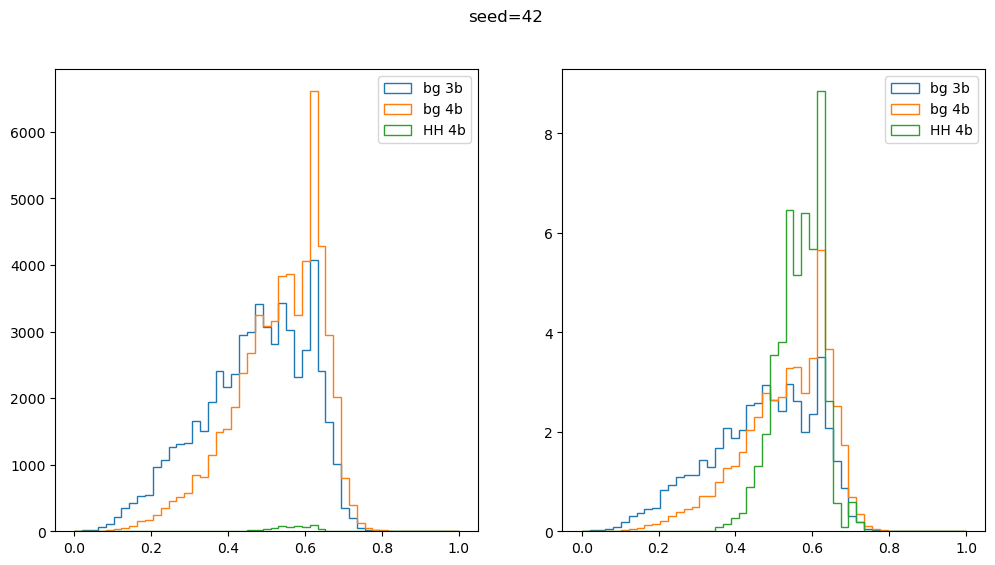

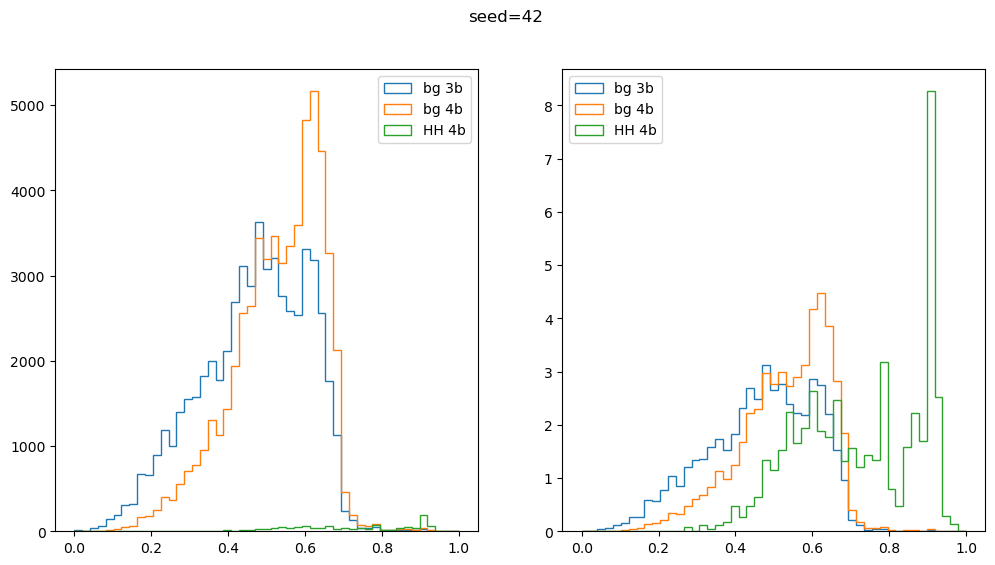

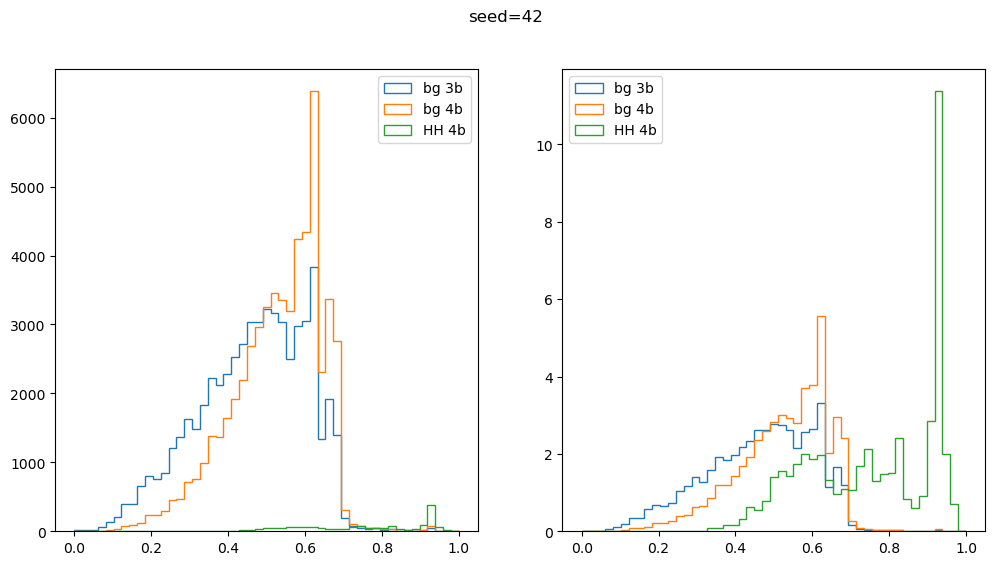

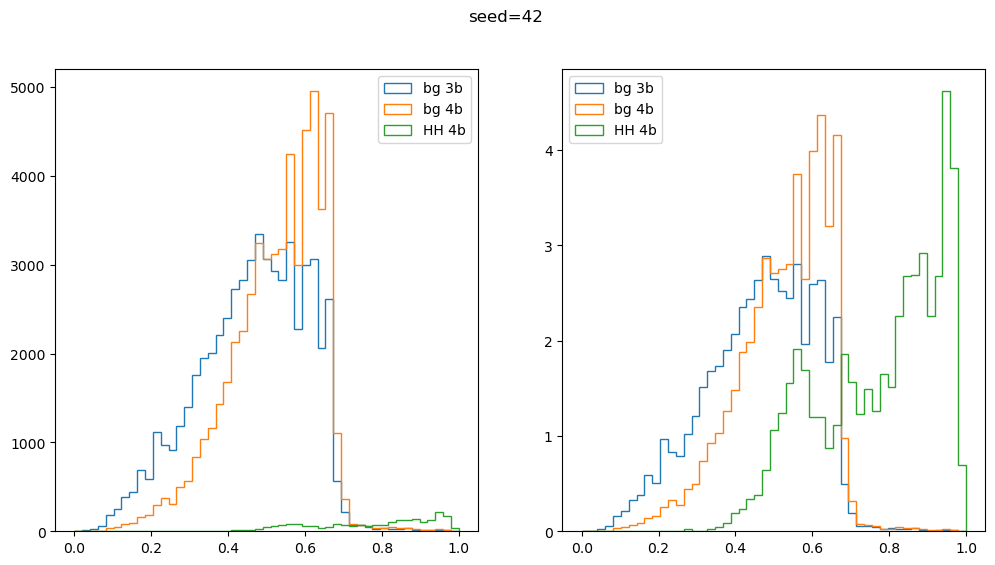

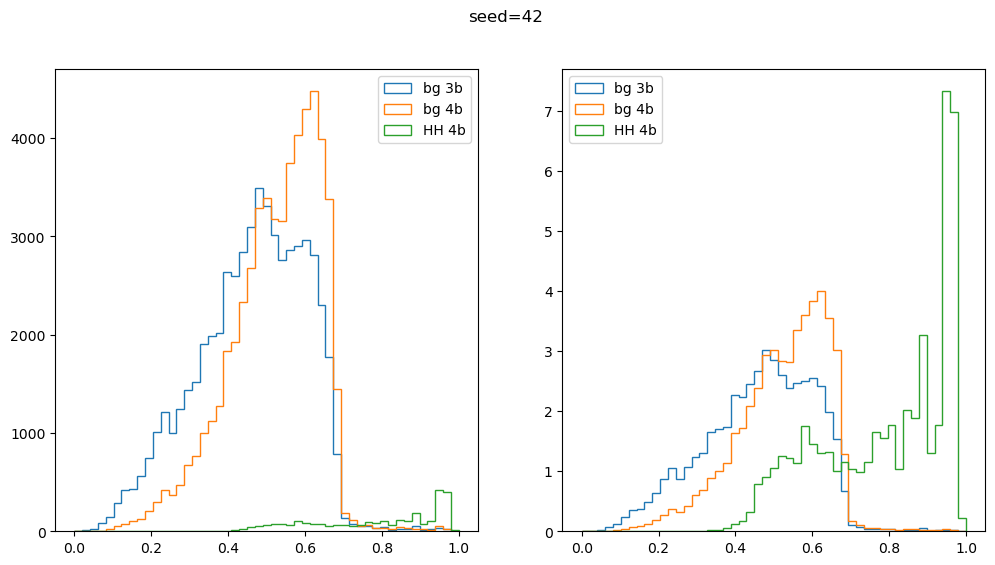

In [10]:
for seed in seeds:
    for signal_ratio in signal_ratios:
        events = events_test_dict[seed][signal_ratio]
        
        hash = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed, 
                                  "signal_ratio": signal_ratio, "n_sample_ratio": 1.0})[0]
        tinfo = TrainingInfo.load(hash)
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        events_sr_train, events_sr_test = events.split(0.5, seed=seed)
        events_sr_train.set_model_scores(fvt_model)
        events_sr_test.set_model_scores(fvt_model)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        fig.suptitle(f"seed={seed}")

        xgbreg = XGBRegressor(n_estimators=20, max_depth=5, random_state=seed)
        xgbreg.fit(events_sr_train.att_q_repr, events_sr_train.is_4b, sample_weight=events_sr_train.weights)
        probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)

        is_3b = events_sr_test.is_3b
        is_bg4b = events_sr_test.is_bg4b
        is_signal = events_sr_test.is_signal
        is_4b = events_sr_test.is_4b
        w = events_sr_test.weights

        bins_range = np.linspace(0, 1, 50)
        ax[0].hist(probs_4b_estimated[is_3b], bins=bins_range, weights=w[is_3b], label="bg 3b", histtype="step")
        ax[0].hist(probs_4b_estimated[is_bg4b], bins=bins_range, weights=w[is_bg4b], label="bg 4b", histtype="step")
        ax[0].hist(probs_4b_estimated[is_signal], bins=bins_range, weights=w[is_signal], label="HH 4b", histtype="step")
        
        ax[1].hist(probs_4b_estimated[is_3b], bins=bins_range, weights=w[is_3b], label="bg 3b", histtype="step", density=True)
        ax[1].hist(probs_4b_estimated[is_bg4b], bins=bins_range, weights=w[is_bg4b], label="bg 4b", histtype="step", density=True)
        ax[1].hist(probs_4b_estimated[is_signal], bins=bins_range, weights=w[is_signal], label="HH 4b", histtype="step", density=True)
            
        ax[0].legend()
        ax[1].legend()
        
        plt.show()
        plt.close()

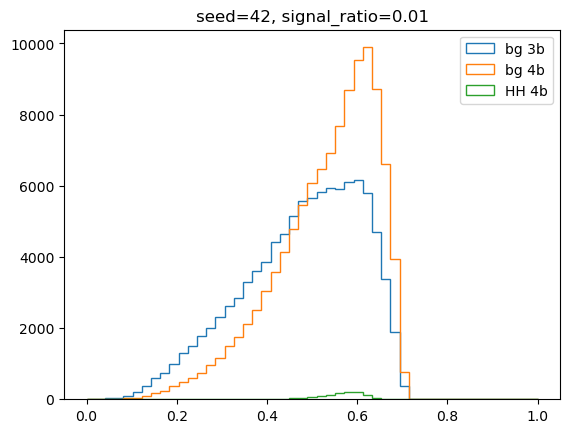

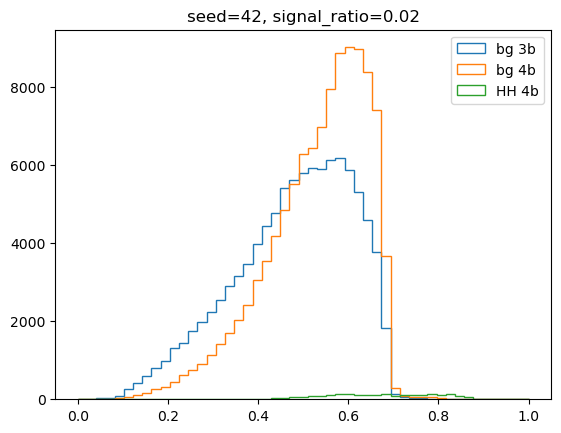

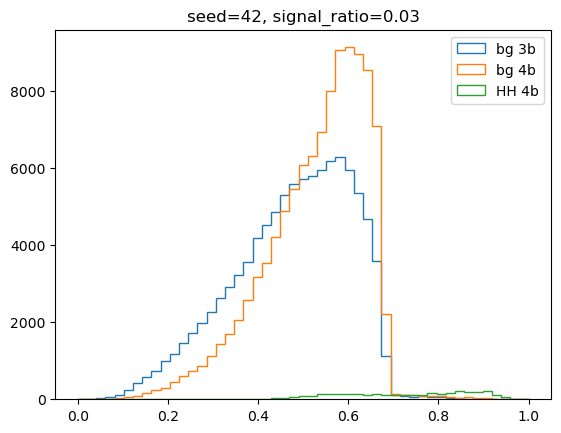

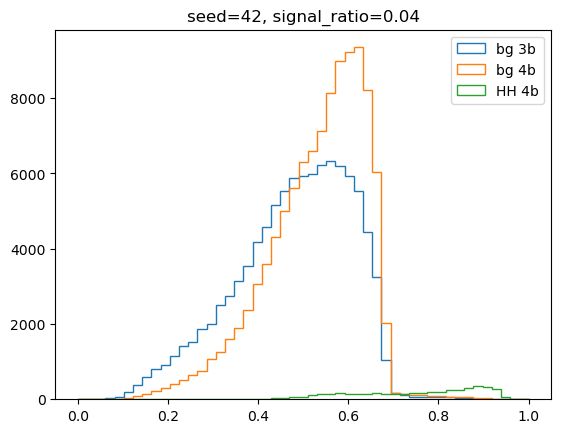

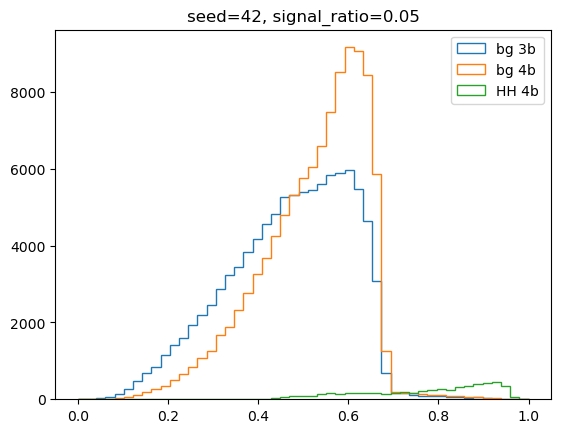

In [8]:
for seed in seeds:
    for signal_ratio in signal_ratios:
        events = events_test_dict[seed][signal_ratio]
        fig, ax = plt.subplots()
        bins_range = np.linspace(0, 1, 50)
        ax.set_title(f"seed={seed}, signal_ratio={signal_ratio}")
        ax.hist(fvt_scores_dict[seed][signal_ratio][events.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax.hist(fvt_scores_dict[seed][signal_ratio][events.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax.hist(fvt_scores_dict[seed][signal_ratio][events.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax.legend()

        plt.show()
        plt.close()

/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Elapsed time: 1.33 s
Elapsed time: 5.90 s


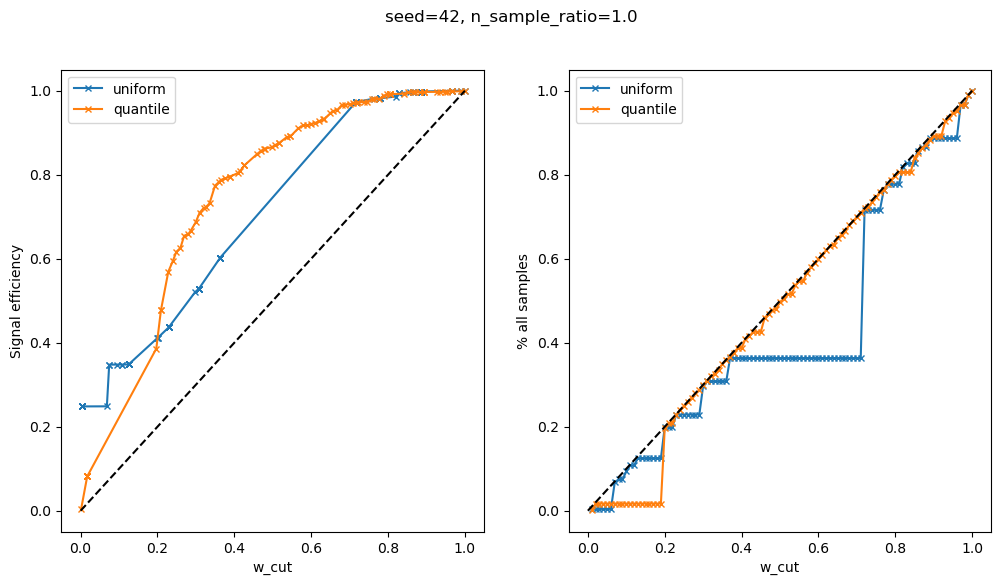

Elapsed time: 2.28 s
Elapsed time: 6.30 s


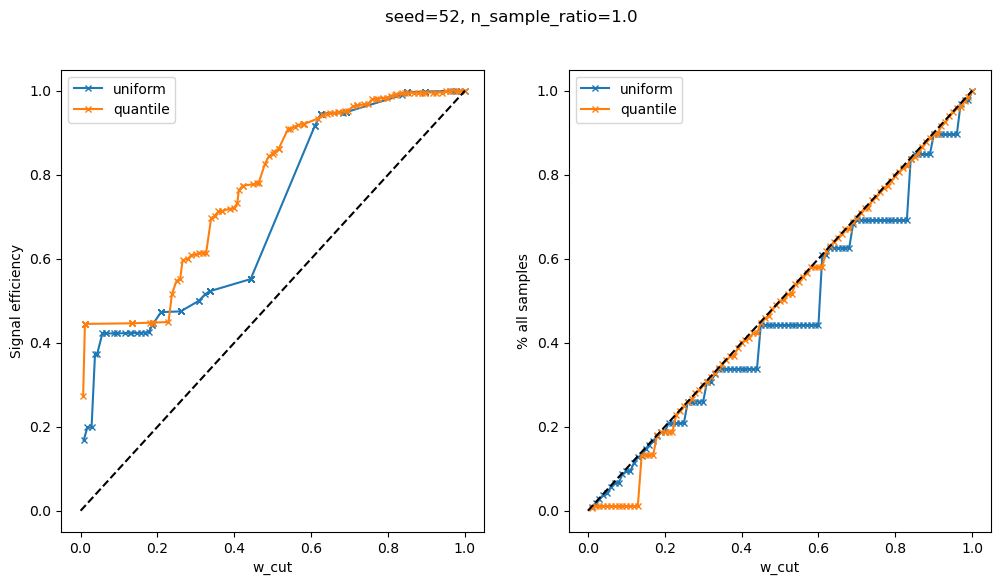

Elapsed time: 2.36 s
Elapsed time: 6.09 s


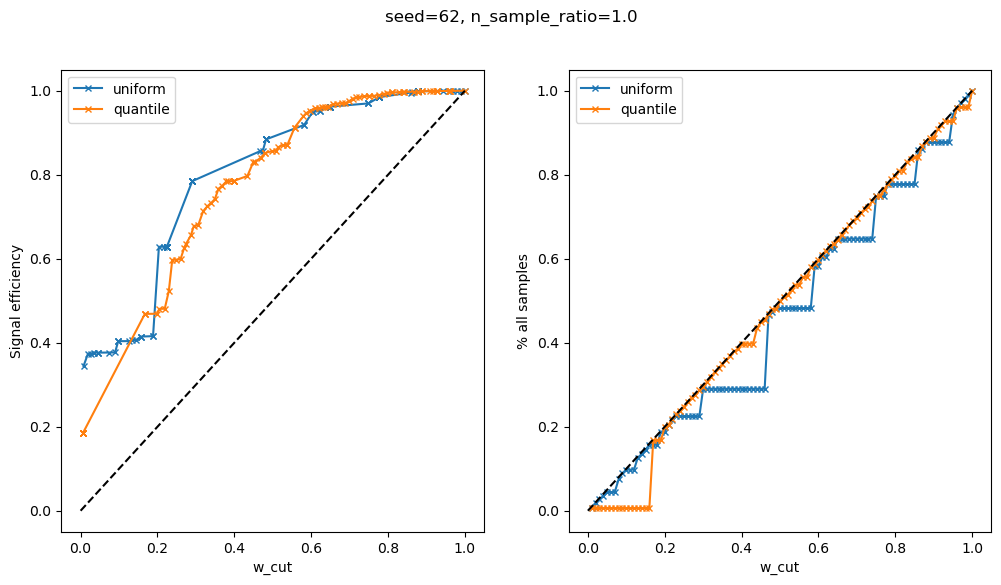

Elapsed time: 4.93 s
Elapsed time: 5.73 s


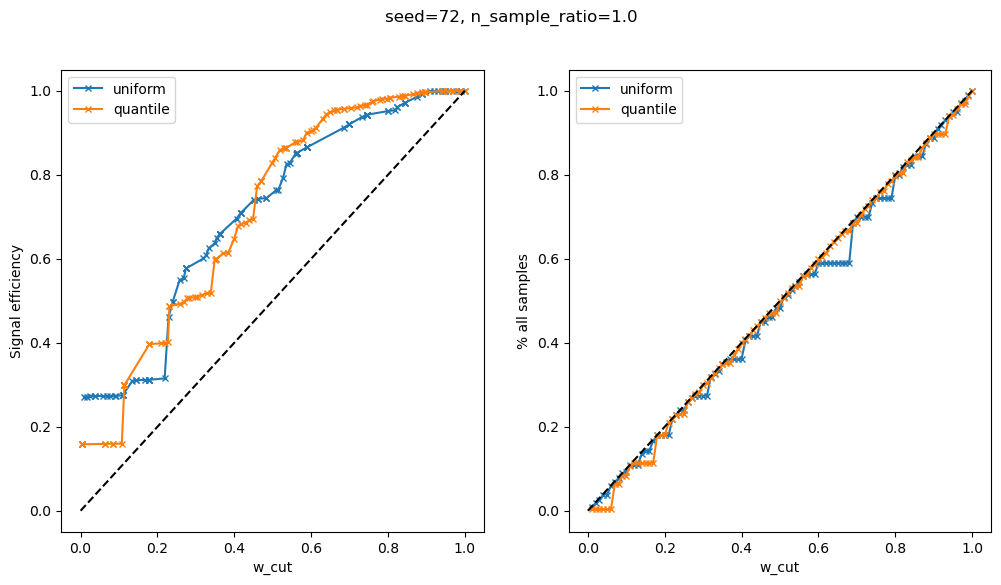

Elapsed time: 5.28 s
Elapsed time: 6.52 s


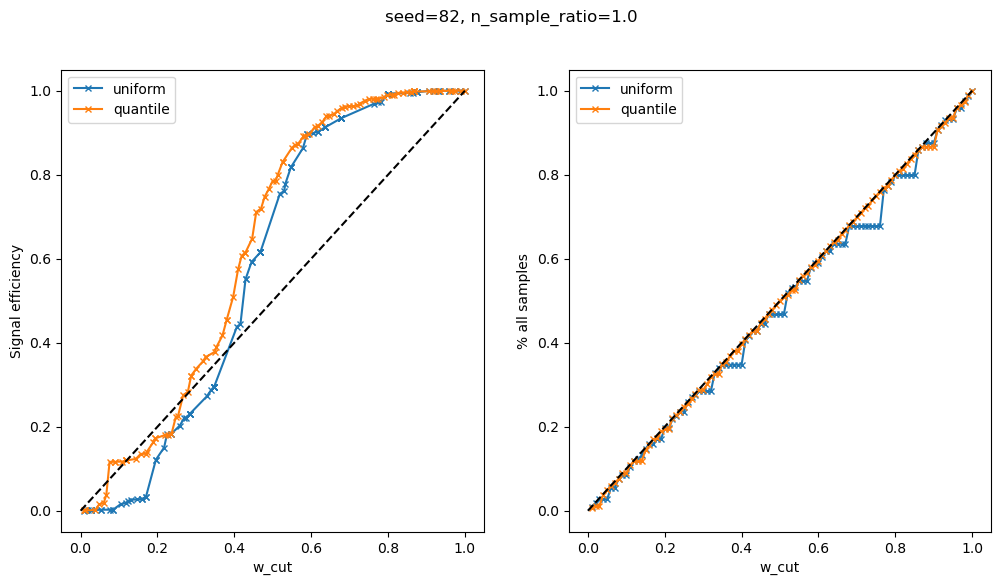

Elapsed time: 0.81 s
Elapsed time: 5.95 s


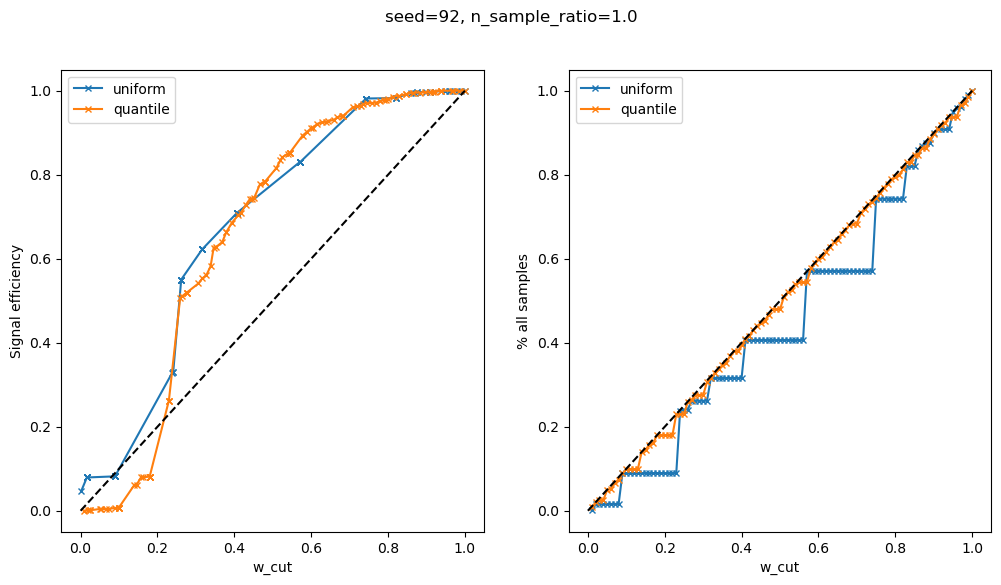

In [ ]:
import time
from signal_region import get_regions_via_histogram

n_sample_ratio = 1.0
using_features = [0, 1, 2, 3, 4, 5]
w_cuts = np.arange(0.01, 1.01, 0.01)

for seed in seeds:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle(f"seed={seed}, n_sample_ratio={n_sample_ratio}")
    # for binning_method in ["uniform"]:
    for binning_method in ["uniform", "quantile"]:
        events = events_test_dict[seed]
        is_3b = events.is_3b
        is_bg4b = events.is_bg4b
        is_signal = events.is_signal
        w = events.weights

        nbins = 6 if binning_method == "uniform" else 3
        
        # for n_sample_ratio in n_sample_ratios:
        att_q_repr = att_q_reprs_dict[seed][n_sample_ratio]

        start_time = time.time()
        is_in_regions_list = get_regions_via_histogram(events, w_cuts, binning_method, nbins)
        print(f"Elapsed time: {time.time() - start_time:.2f} s")

        w_signal = np.array([np.sum(w[is_signal & is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w[is_signal])
        w_all = np.array([np.sum(w[is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w)

        ax[0].plot( 
            w_all,
            w_signal,
            label=binning_method,
            marker="x",
            markersize=5
        )
        ax[1].plot(
            w_cuts,
            w_all,
            label=binning_method,
            marker="x",
            markersize=5
        )

    ax[0].plot([0, 1], [0, 1], linestyle="--", color="black")
    ax[0].set_xlabel("w_cut")
    ax[0].set_ylabel("Signal efficiency")
    ax[0].legend()

    ax[1].plot([0, 1], [0, 1], linestyle="--", color="black")
    ax[1].set_xlabel("w_cut")
    ax[1].set_ylabel("% all samples")
    ax[1].legend()

    plt.show()
    plt.close()


quantile
nonzero bins 1850
% nonzero bins 0.4517


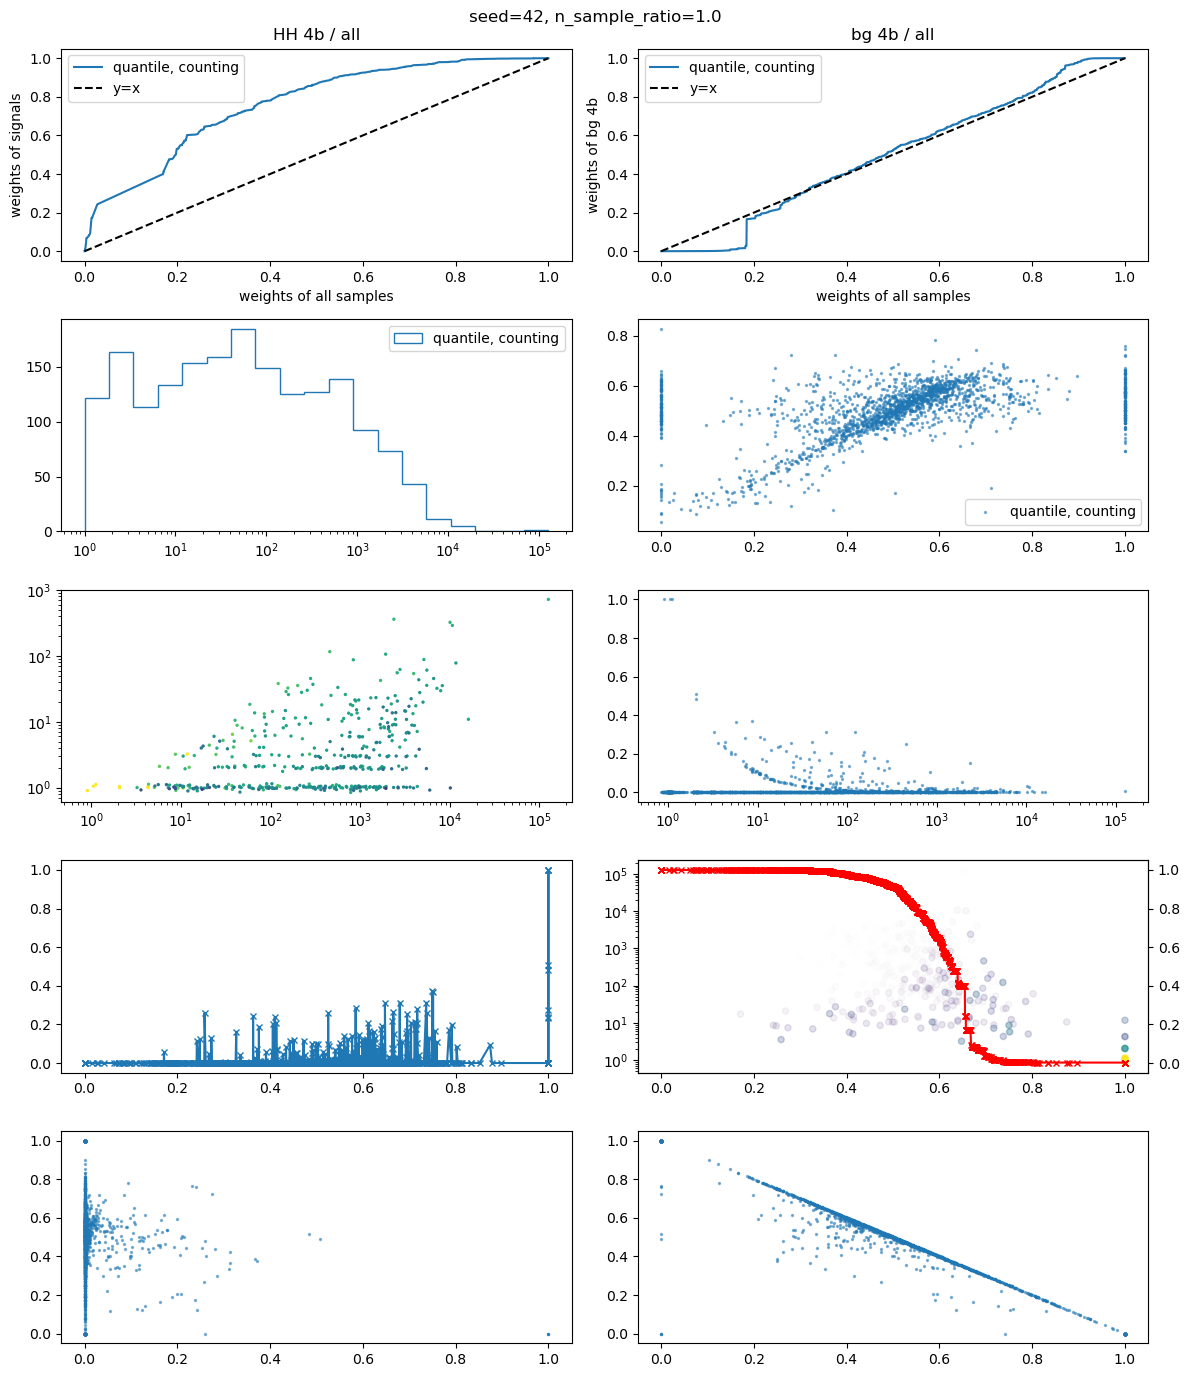

quantile
nonzero bins 1996
% nonzero bins 0.4873


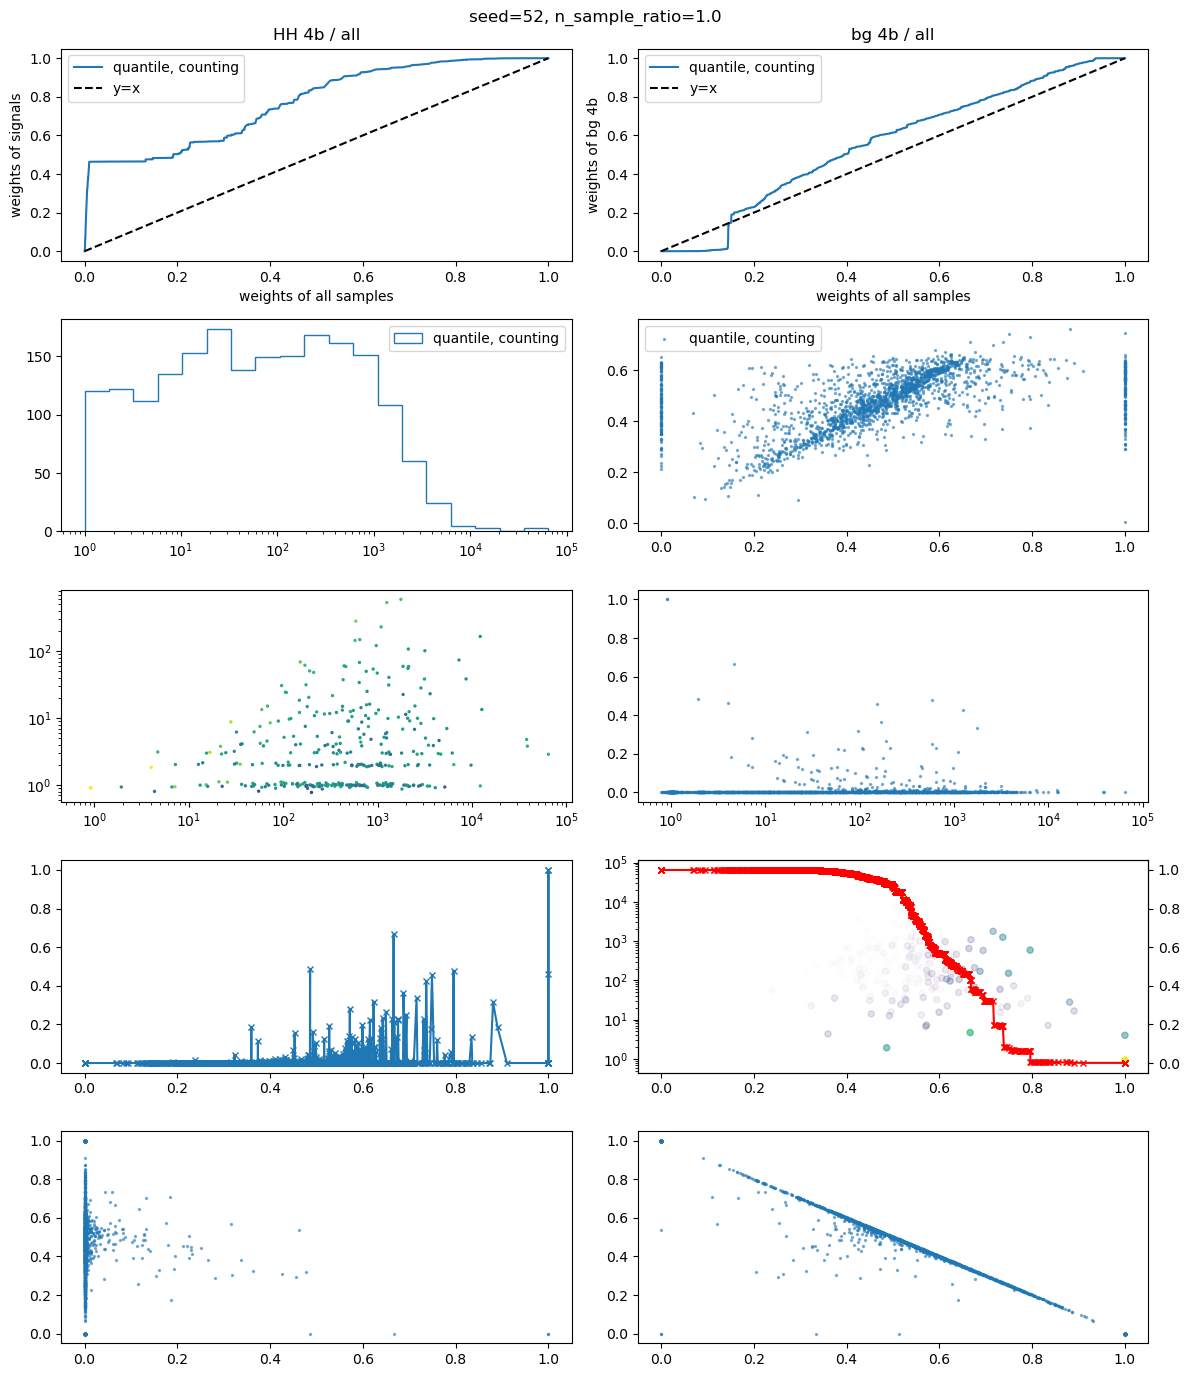

quantile
nonzero bins 2080
% nonzero bins 0.5078


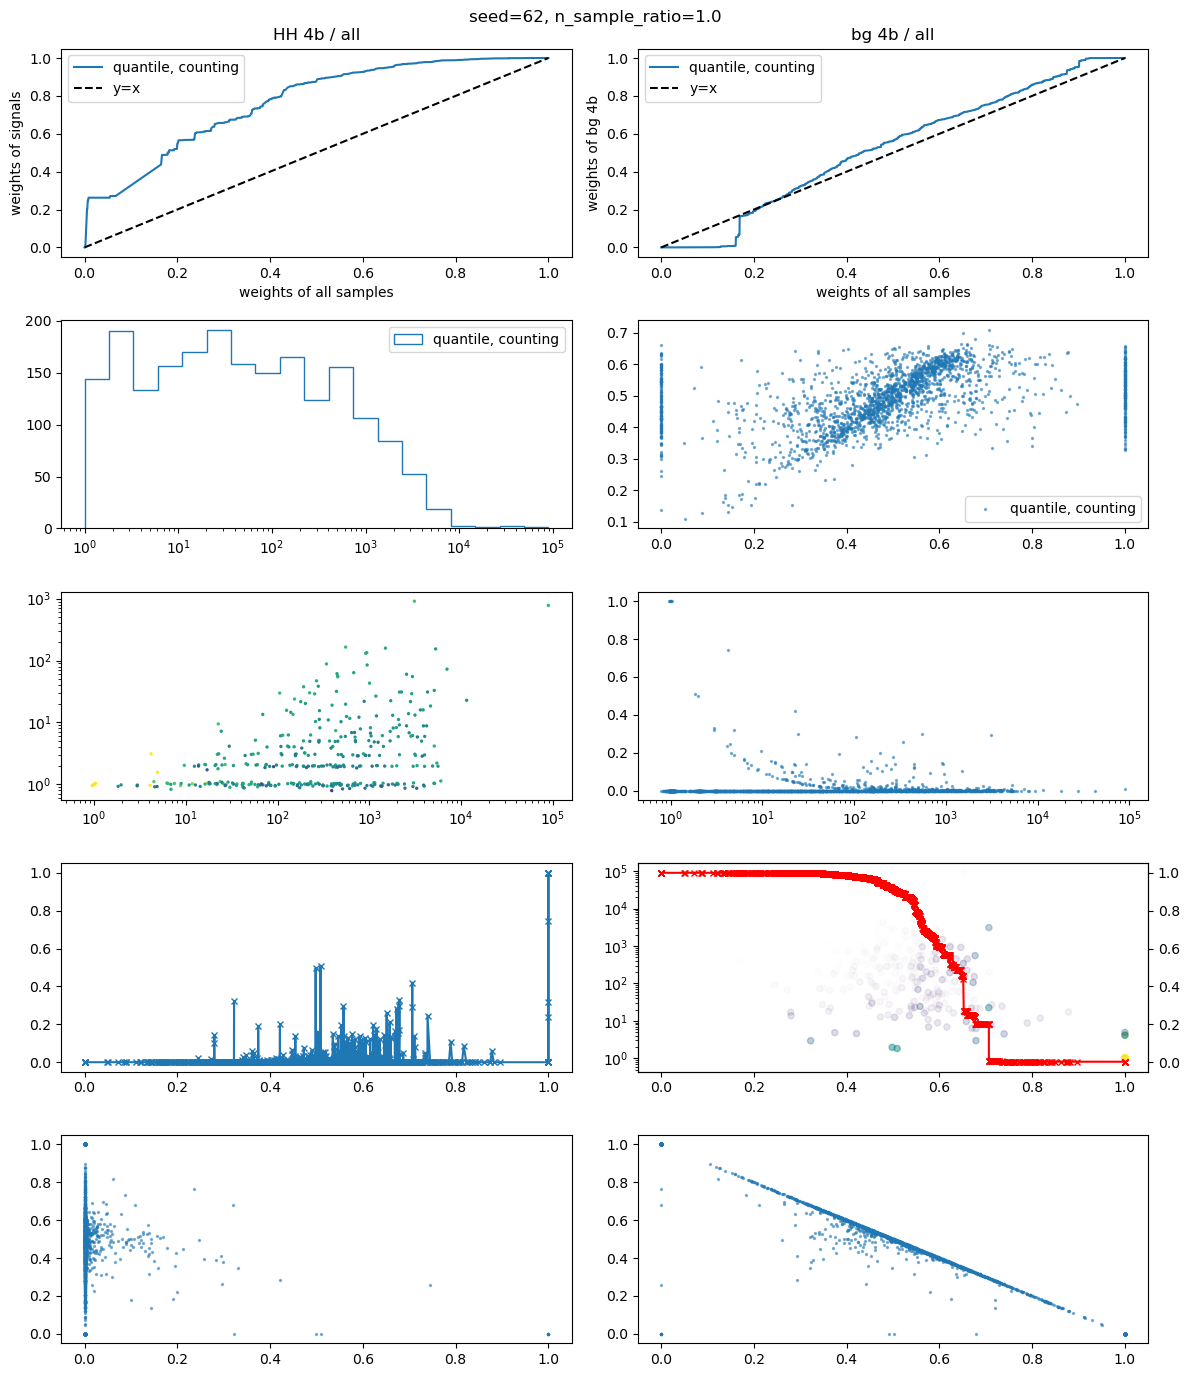

quantile
nonzero bins 1729
% nonzero bins 0.4221


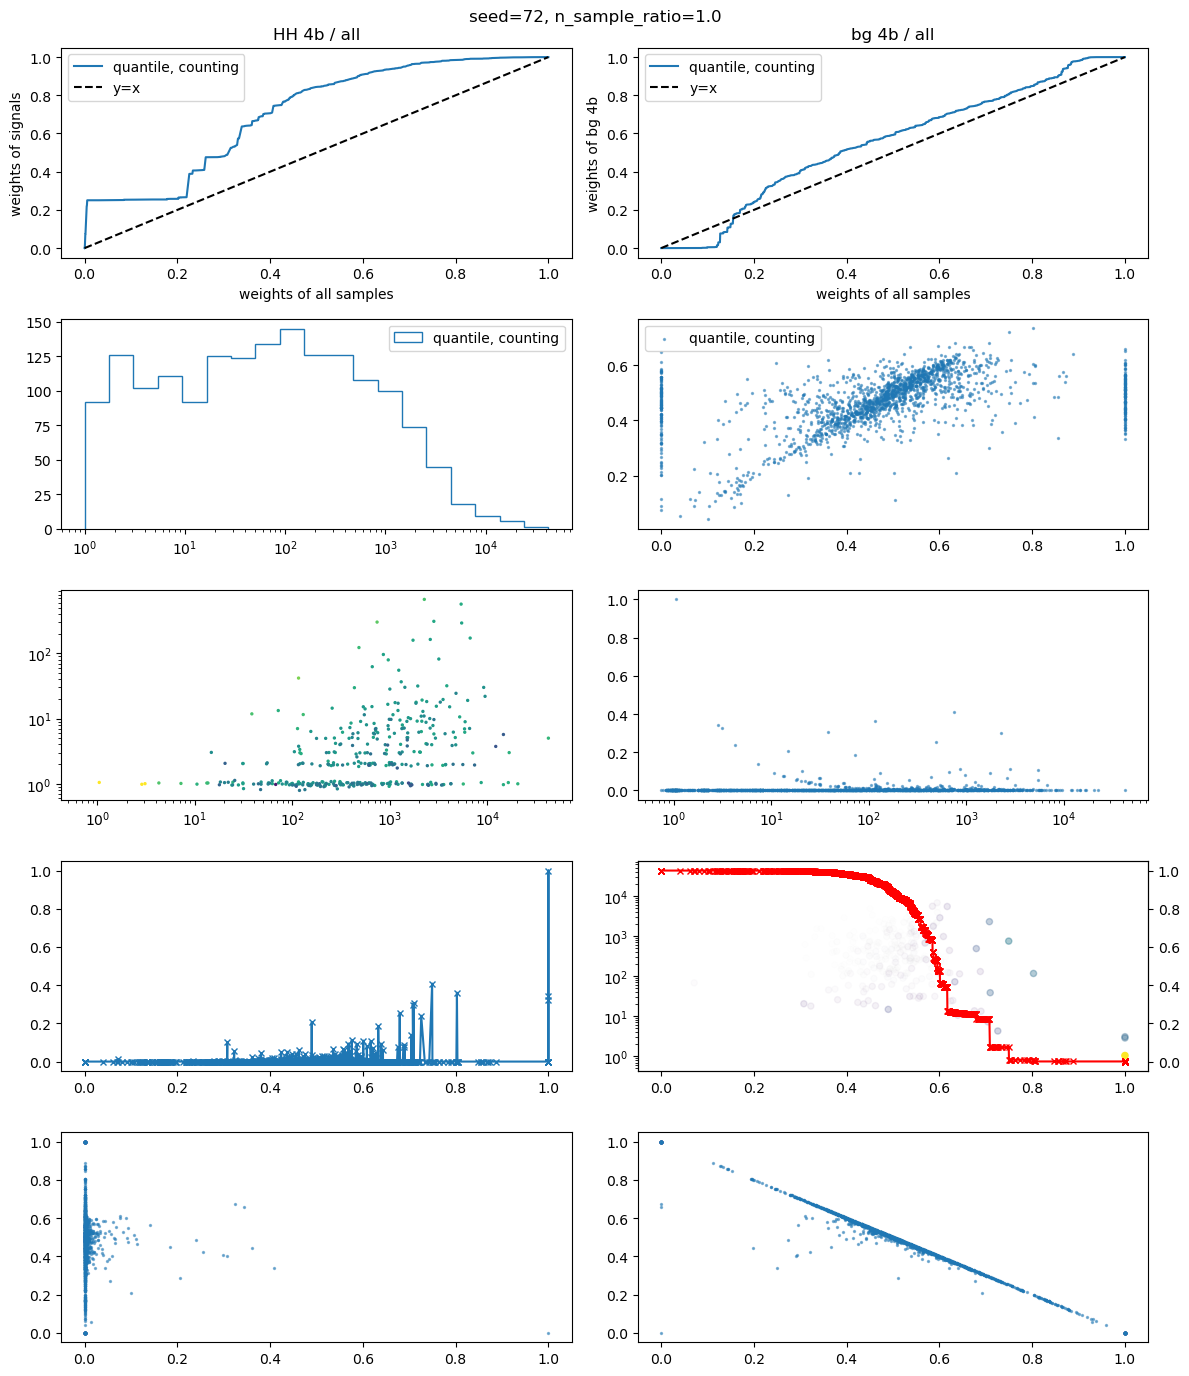

quantile
nonzero bins 2407
% nonzero bins 0.5876


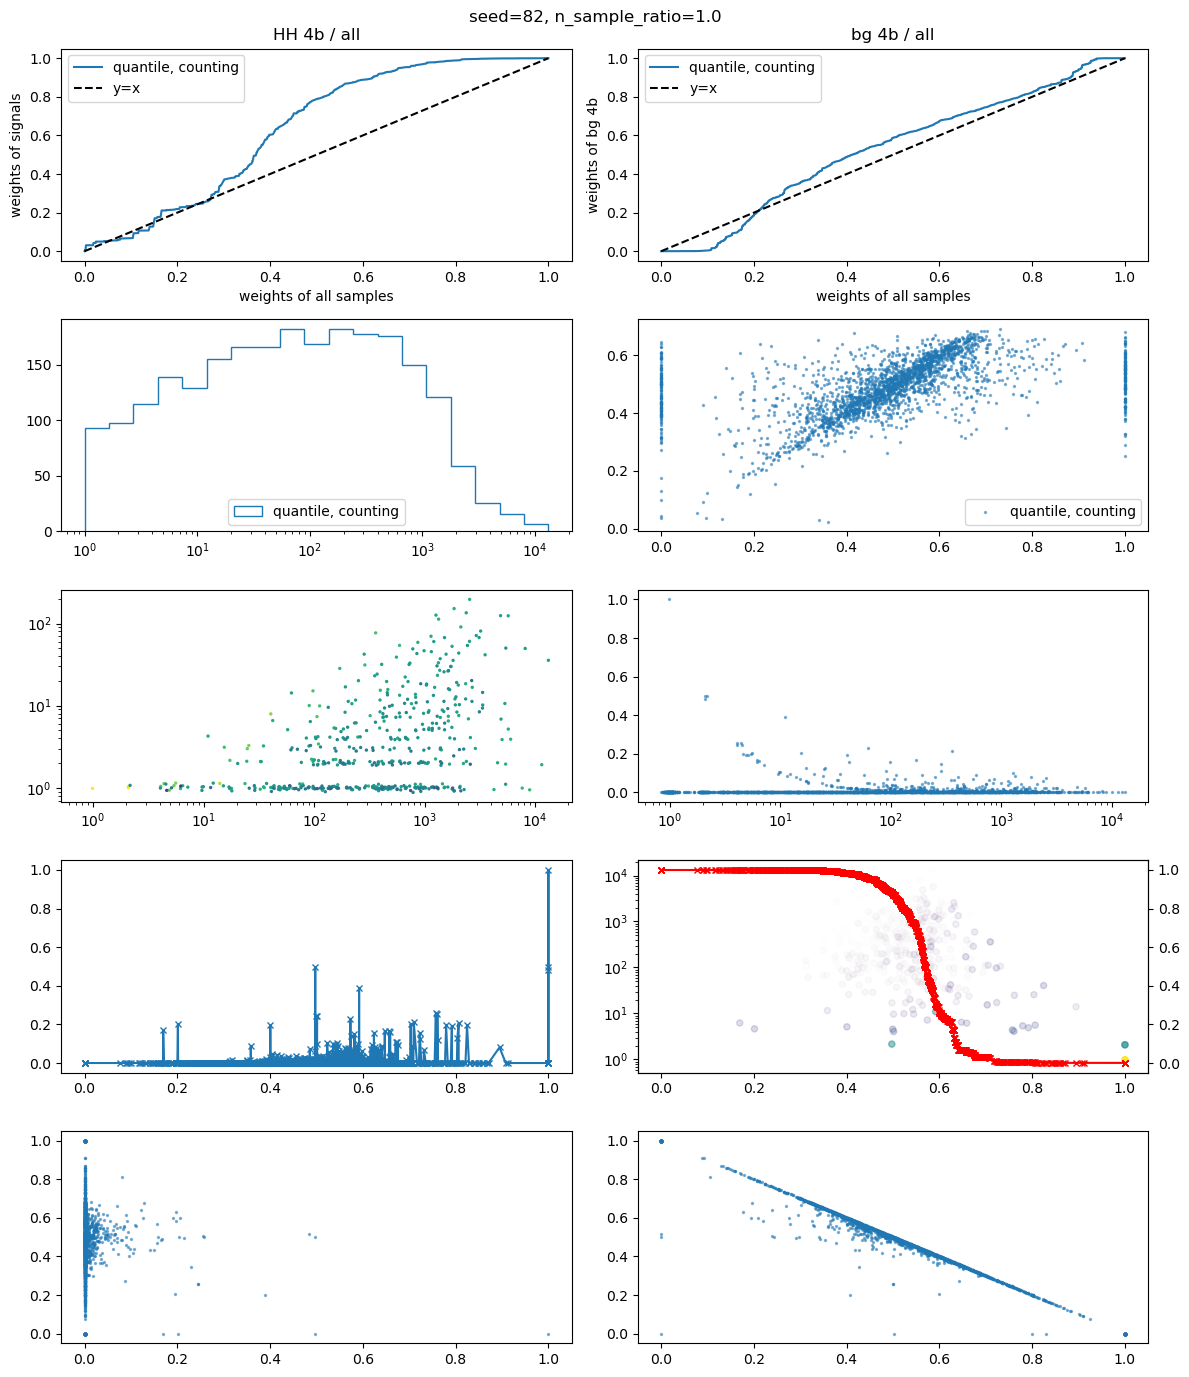

quantile
nonzero bins 1975
% nonzero bins 0.4822


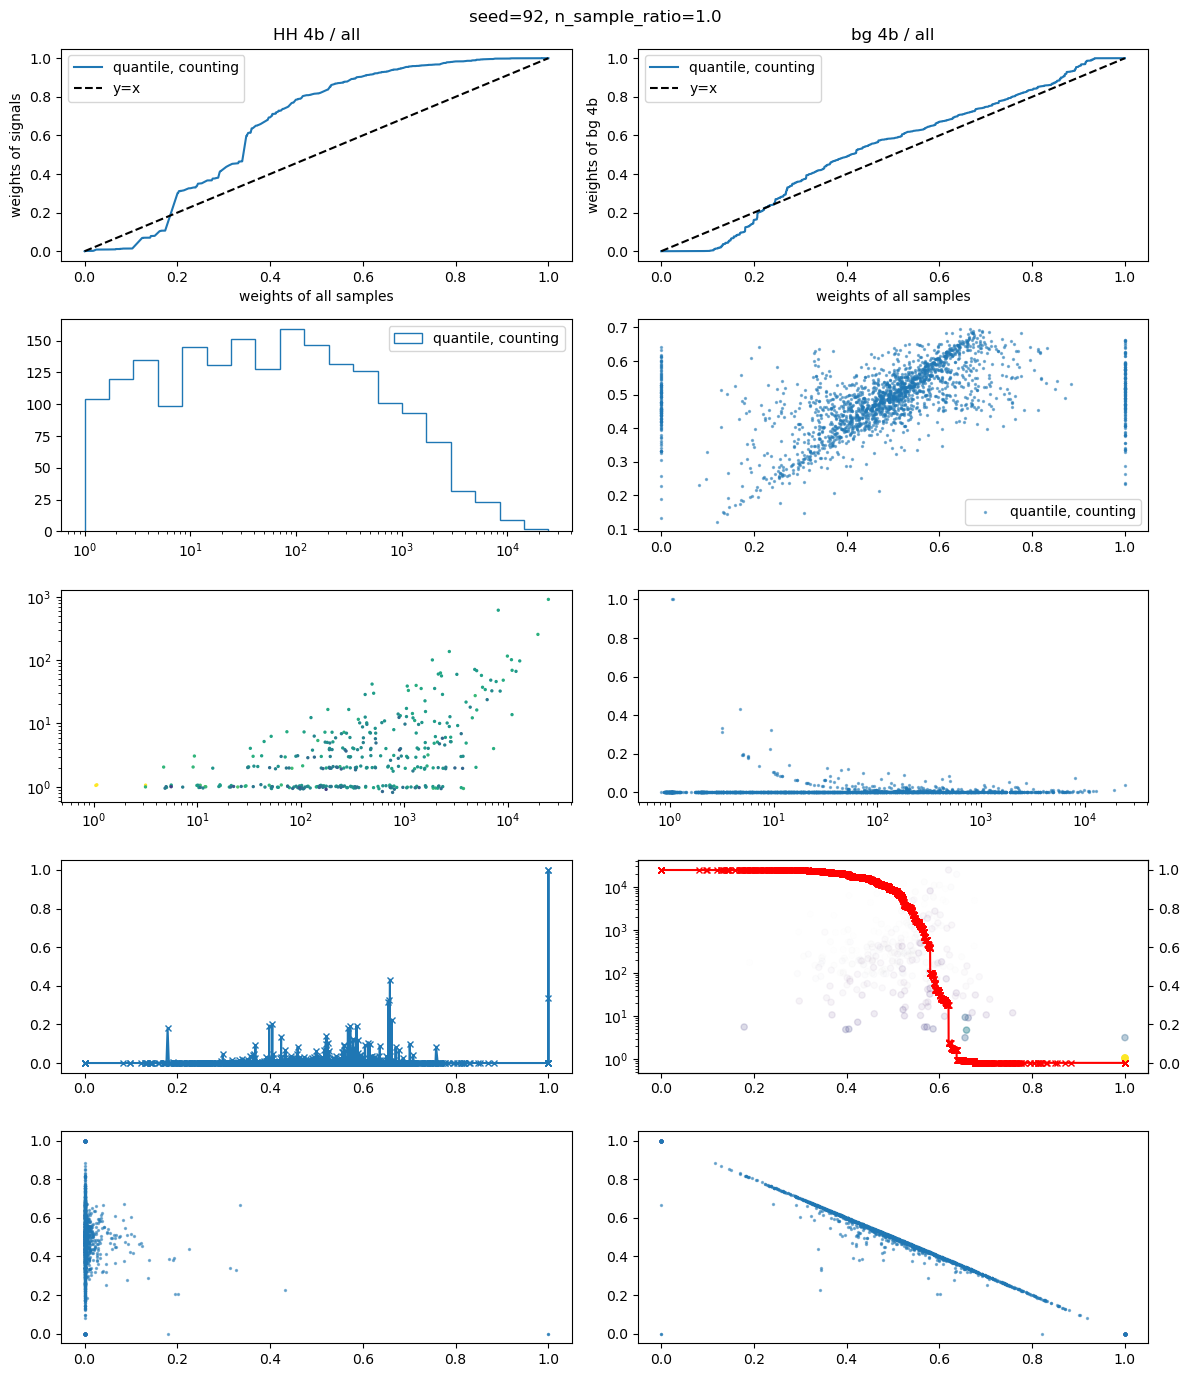

In [ ]:
n_sample_ratio = 1.0
using_features = [0, 1, 2, 3, 4, 5]
nbins = 5
p4b_method = "counting"

for seed in seeds:
    events = events_test_dict[seed]
    is_3b = events.is_3b
    is_bg4b = events.is_bg4b
    is_signal = events.is_signal
    is_4b = is_bg4b | is_signal
    att_q_repr = att_q_reprs_dict[seed][n_sample_ratio]

    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 14))
    fig.suptitle(f"seed={seed}, n_sample_ratio={n_sample_ratio}")

    # for n_sample_ratio in n_sample_ratios:

    for binning_method in ["quantile"]:
        if binning_method == "uniform":
                bins_range = [np.linspace(np.min(att_q_repr[:, i]), np.max(att_q_repr[:, i]), nbins) 
                        for i in using_features]
        elif binning_method == "quantile":
            bins_range = [np.quantile(att_q_repr[:, i], np.linspace(0, 1, nbins)) for i in using_features]
        else:
            raise ValueError("Invalid binning method")
        
        hist_3b, _ = np.histogramdd(att_q_repr[is_3b][:, using_features], 
                                    bins=bins_range, weights=events.weights[is_3b])
        hist_bg4b, _ = np.histogramdd(att_q_repr[is_bg4b][:, using_features], 
                                    bins=bins_range, weights=events.weights[is_bg4b])
        hist_signal, _ = np.histogramdd(att_q_repr[is_signal][:, using_features], 
                                    bins=bins_range, weights=events.weights[is_signal])
        hist_fvt, _ = np.histogramdd(att_q_repr[:, using_features],
                                    bins=bins_range, weights=events.fvt_score * events.weights)
        hist_counts, _ = np.histogramdd(att_q_repr[:, using_features], bins=bins_range)
        hist_4b = hist_bg4b + hist_signal
        hist_all = hist_3b + hist_4b
        is_nonzero = hist_all > 0
        
        with np.errstate(divide="ignore", invalid="ignore"):
            ratio_4b = hist_4b / hist_all
            ratio_signal = hist_signal / hist_all

        print(binning_method)
        print("nonzero bins", np.sum(is_nonzero))
        print("% nonzero bins {:.4f}".format(np.sum(is_nonzero) / np.prod(hist_all.shape)))
        
        for p4b_method in ["counting"]:
            if p4b_method == "counting": 
                sorted_idx = np.argsort(ratio_4b[is_nonzero].flatten())[::-1]
            elif p4b_method == "fvt":
                sorted_idx = np.argsort((hist_fvt / hist_all)[is_nonzero].flatten())[::-1]
            else:
                raise ValueError("Invalid p4b_method")

            ax[0, 0].plot(
                np.cumsum(hist_all[is_nonzero][sorted_idx]) / np.sum(hist_all),
                np.cumsum(hist_signal[is_nonzero][sorted_idx]) / np.sum(hist_signal),
                label="{}, {}".format(binning_method, p4b_method)
            )

            ax[0, 1].plot(
                np.linspace(0, 1, np.sum(is_nonzero)),
                np.cumsum(hist_all[is_nonzero][sorted_idx]) / np.sum(hist_all),
                label="{}, {}".format(binning_method, p4b_method)
            )
            

            bins_range = np.geomspace(1, np.max(hist_all), 20)
            ax[1, 0].hist(hist_all[is_nonzero], label="{}, {}".format(binning_method, p4b_method), 
                          histtype="step", bins=bins_range)
            ax[1, 1].scatter(ratio_4b[is_nonzero], hist_fvt[is_nonzero] / hist_all[is_nonzero],
                            label="{}, {}".format(binning_method, p4b_method), s=2, alpha=0.5)
            
            
            ax[2, 0].scatter(hist_all[is_nonzero][sorted_idx], hist_signal[is_nonzero][sorted_idx],
                            label="{}, {}".format(binning_method, p4b_method), s=2, 
                            c=hist_4b[is_nonzero][sorted_idx] / hist_all[is_nonzero][sorted_idx])
            
            ax[2, 1].scatter(hist_all[is_nonzero], (hist_signal[is_nonzero] / hist_all[is_nonzero]),
                            label="{}, {}".format(binning_method, p4b_method), s=2, alpha=0.5)

            ax[3, 0].plot(hist_4b[is_nonzero][sorted_idx] / hist_all[is_nonzero][sorted_idx], 
                            hist_signal[is_nonzero][sorted_idx] / hist_all[is_nonzero][sorted_idx],
                            label="{}, {}".format(binning_method, p4b_method), 
                            marker="x", markersize=5)
            
            ax[3, 1].scatter(hist_4b[is_nonzero][sorted_idx] / hist_all[is_nonzero][sorted_idx], 
                            hist_all[is_nonzero][sorted_idx],
                            label="{}, {}".format(binning_method, p4b_method), 
                            c=hist_signal[is_nonzero][sorted_idx] / hist_all[is_nonzero][sorted_idx],
                            cmap="viridis", s=20, alpha=hist_signal[is_nonzero][sorted_idx] / hist_all[is_nonzero][sorted_idx])
            
            twinx = ax[3, 1].twinx()
            twinx.plot(hist_4b[is_nonzero][sorted_idx] / hist_all[is_nonzero][sorted_idx],
                       np.cumsum(hist_signal[is_nonzero][sorted_idx]) / np.sum(hist_signal),
                          color="red", label="cumulative signal efficiency", 
                          marker="x", markersize=5)
            
            ax[4, 0].scatter(hist_signal[is_nonzero] / hist_all[is_nonzero],
                            hist_bg4b[is_nonzero] / hist_all[is_nonzero],
                            label="{}, {}".format(binning_method, p4b_method), s=2, alpha=0.5)
            
            ax[4, 1].scatter(hist_3b[is_nonzero] / hist_all[is_nonzero],
                          hist_bg4b[is_nonzero] / hist_all[is_nonzero],
                            label="{}, {}".format(binning_method, p4b_method), s=2, alpha=0.5)

            

    ax[0, 0].set_title("HH 4b / all")
    ax[0, 0].set_xlabel("weights of all samples")
    ax[0, 0].set_ylabel("weights of signals")
    ax[0, 0].plot([0, 1], [0, 1], "--", color="black", label="y=x")

    ax[0, 1].set_title("bg 4b / all")
    ax[0, 1].set_xlabel("weights of all samples")
    ax[0, 1].set_ylabel("weights of bg 4b")
    ax[0, 1].plot([0, 1], [0, 1], "--", color="black", label="y=x")
    

    ax[1, 0].set_xscale("log")
    ax[2, 0].set_xscale("log")
    ax[2, 0].set_yscale("log")
    ax[2, 1].set_xscale("log")
    ax[3, 1].set_yscale("log")

    # ax[4, 0].plot([0, 1], [0, 1], "--", color="black", label="y=x")

    for ax_cnt in range(2):
        ax[ax_cnt, 0].legend()
        ax[ax_cnt, 1].legend()

    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
from ancillary_features import jets_to_dijets
from signal_region import get_regions_via_probs_4b
from xgboost import XGBRegressor


seed = 42
n_sample_ratio = 1.0
using_features = [0, 1, 2, 3, 4, 5]
w_cuts = np.arange(0.01, 1.01, 0.01)
# nbins = 4
# binning_method = "quantile"

events = events_test_dict[seed]
att_q_repr = att_q_reprs_dict[seed][n_sample_ratio]


xgbreg = XGBRegressor(n_estimators=best_n_estimator, max_depth=best_max_depth, random_state=seed)
xgbreg.fit(att_q_repr, events.is_4b, sample_weight=events.weights)
probs_4b_est = xgbreg.predict(att_q_repr)
is_in_regions_list = get_regions_via_probs_4b(events, w_cuts, probs_4b_est)

jet0 = events.X_torch[:, [4*i for i in range(4)]]
jet1 = events.X_torch[:, [4*i + 1 for i in range(4)]]
jet2 = events.X_torch[:, [4*i + 2 for i in range(4)]]
jet3 = events.X_torch[:, [4*i + 3 for i in range(4)]]

dijet01, dijet23, dijet02, dijet13, dijet03, dijet12 = jets_to_dijets(jet0, jet1, jet2, jet3, dim=2)
M01, M23, M02, M13, M03, M12 = dijet01[:, 3], dijet23[:, 3], dijet02[:, 3], dijet13[:, 3], dijet03[:, 3], dijet12[:, 3]
M01, M23, M02, M13, M03, M12 = M01.cpu().numpy(), M23.cpu().numpy(), M02.cpu().numpy(), M13.cpu().numpy(), M03.cpu().numpy(), M12.cpu().numpy()

m_diff = np.stack(
    [M01 - M23, M02 - M13, M03 - M12],
    axis=1
)
m_diff_argmin = np.argmin(np.abs(m_diff), axis=1)

m_0 = np.where(m_diff_argmin == 0, M01, np.where(m_diff_argmin == 1, M02, M03))
m_1 = np.where(m_diff_argmin == 0, M23, np.where(m_diff_argmin == 1, M13, M12))

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

plot_w_cuts = np.arange(0.05, 1.0, 0.05)

fig_m0m1 = go.Figure()

# 2d histogram of m_0[is_in_regions] vs m_1[is_in_regions] for each w_cut
# use plotly express to plot the 2d histogram
# make plot_w_cuts a slider

for w_cut in plot_w_cuts:
    is_in_regions = is_in_regions_list[int(w_cut * 100)]


    x_bins = np.linspace(0, 200, 50)
    y_bins = np.linspace(0, 200, 50)

    hist_sr, _, _ = np.histogram2d(m_0[is_in_regions], m_1[is_in_regions], bins=(x_bins, y_bins),
                                    weights=events.weights[is_in_regions])
    hist_sr = hist_sr.T
    hist_sr /= np.sum(hist_sr)

    fig_m0m1.add_trace(
        go.Heatmap(
            x=x_bins,
            y=y_bins,
            z=hist_sr,
            zmin=0,
            zmax=0.005,
            colorscale="Viridis",
            name=f"w_cut={w_cut:.1f}",
            visible=False,
        )
    )

fig_m0m1.data[0].visible = True

steps = []
for i in range(len(fig_m0m1.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig_m0m1.data)}],
        label=f"{plot_w_cuts[i]:.2f}",
    )
    step["args"][0]["visible"][i] = True
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "w_cut: "},
    pad={"t": 50},
    steps=steps
)]


fig_m0m1.update_layout(
    sliders=sliders,
    title="M_0 vs M_1 in signal region",
    xaxis_title="M_0",
    yaxis_title="M_1",
    autosize=False,
    width=600,
    height=600,
    yaxis=dict(scaleanchor="x", scaleratio=1),
)


fig_m0m1.show()

In [ ]:
# fig = go.Figure()
# plot_w_cuts = np.arange(0.2, 1.0, 0.2)

# for w_cut in plot_w_cuts:
#     is_in_regions = is_in_regions_list[int(w_cut * 100)]

#     fig.add_trace(
#         go.Histogram(
#             x=events.fvt_score[is_in_regions],
#             xbins=dict(size=1/30),
#             histnorm="",
#             name=f"SR",
#             visible=False,
#         )
#     )

#     fig.add_trace(
#         go.Histogram(
#             x=events.fvt_score[~is_in_regions],
#             xbins=dict(size=1/30),
#             histnorm="",
#             name="not SR",
#             visible=False,
#         )
#     )

# fig.data[0].visible = True
# fig.data[1].visible = True

# steps = []
# for i in range(0, len(fig.data), 2):
#     step = dict(
#         method="update",
#         args=[{"visible": [False] * len(fig.data)}],
#         label=f"{plot_w_cuts[i // 2]:.2f}",
#     )
#     step["args"][0]["visible"][i] = True
#     step["args"][0]["visible"][i + 1] = True
#     steps.append(step)

# sliders = [dict(
#     active=0,
#     currentvalue={"prefix": "w_cut: "},
#     pad={"t": 50},
#     steps=steps
# )]

# fig.update_layout(
#     sliders=sliders,
#     title="FvT score in signal region",
#     xaxis_title="FvT score",
#     yaxis_title="Density",
# )

# fig.show()

# What if we naively use XGBoost on original features?

Signal 4b scores
XGBoost - original features:  0.5358688
XGBoost - q_repr and view_score:  0.56625867
XGBoost - att_q_repr:  0.5695719
FvT NN:  0.5618658


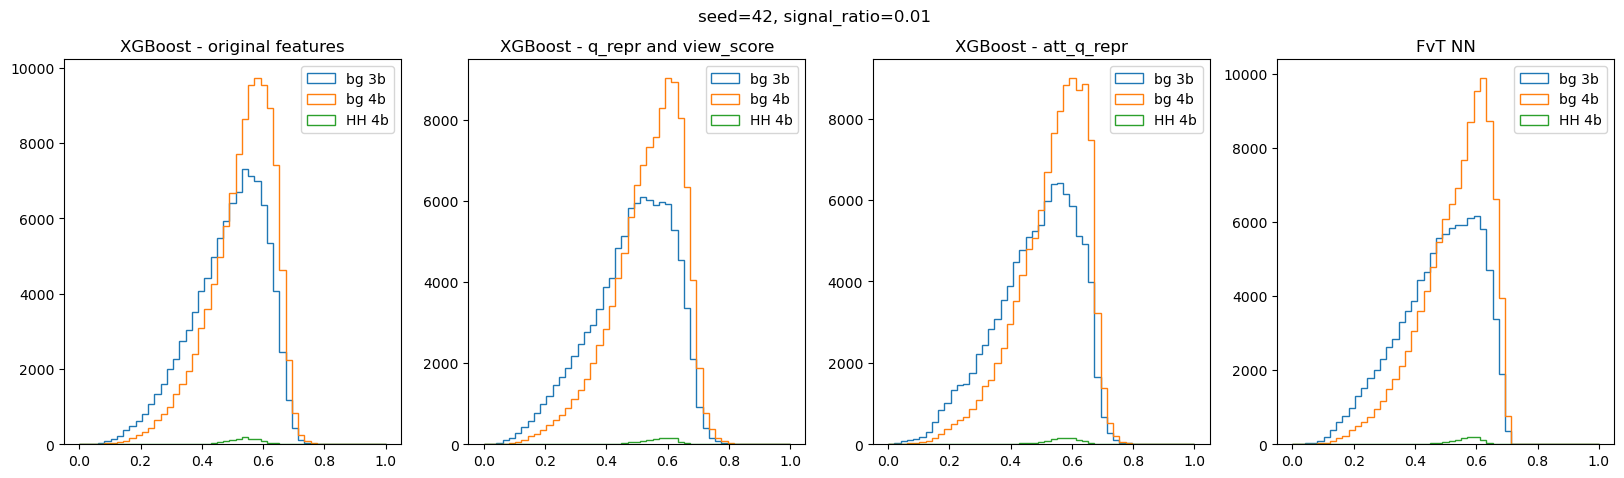

Signal 4b scores
XGBoost - original features:  0.54302514
XGBoost - q_repr and view_score:  0.7010074
XGBoost - att_q_repr:  0.70572466
FvT NN:  0.6701955


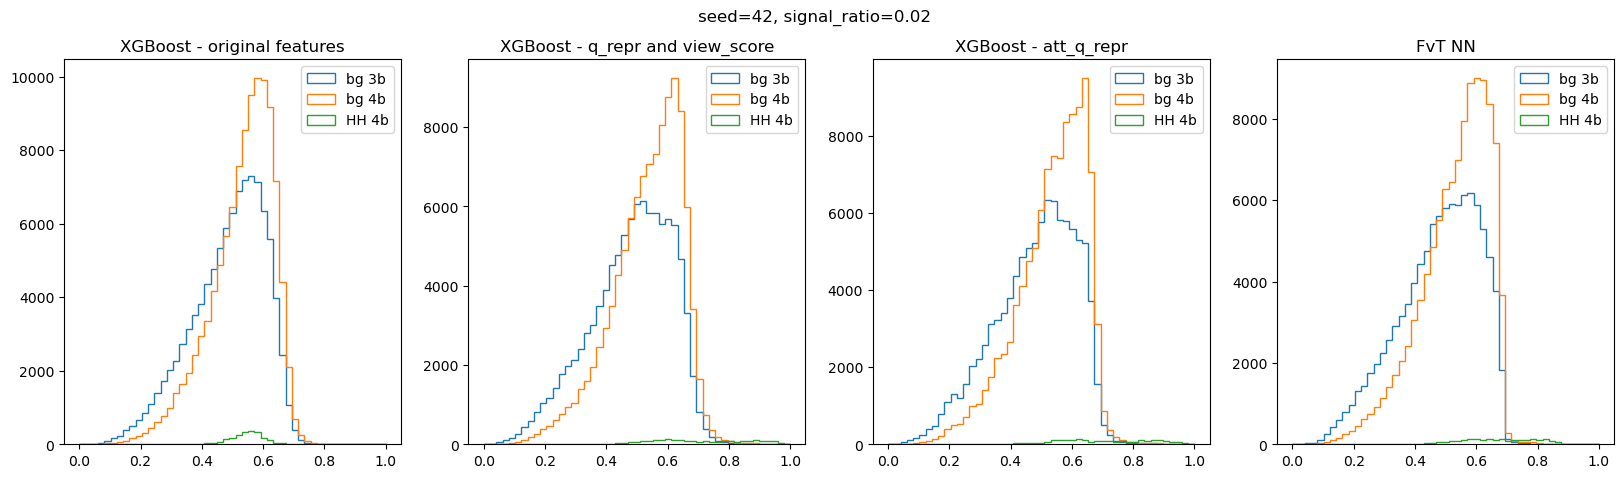

Signal 4b scores
XGBoost - original features:  0.549851
XGBoost - q_repr and view_score:  0.7371902
XGBoost - att_q_repr:  0.74070436
FvT NN:  0.7260688


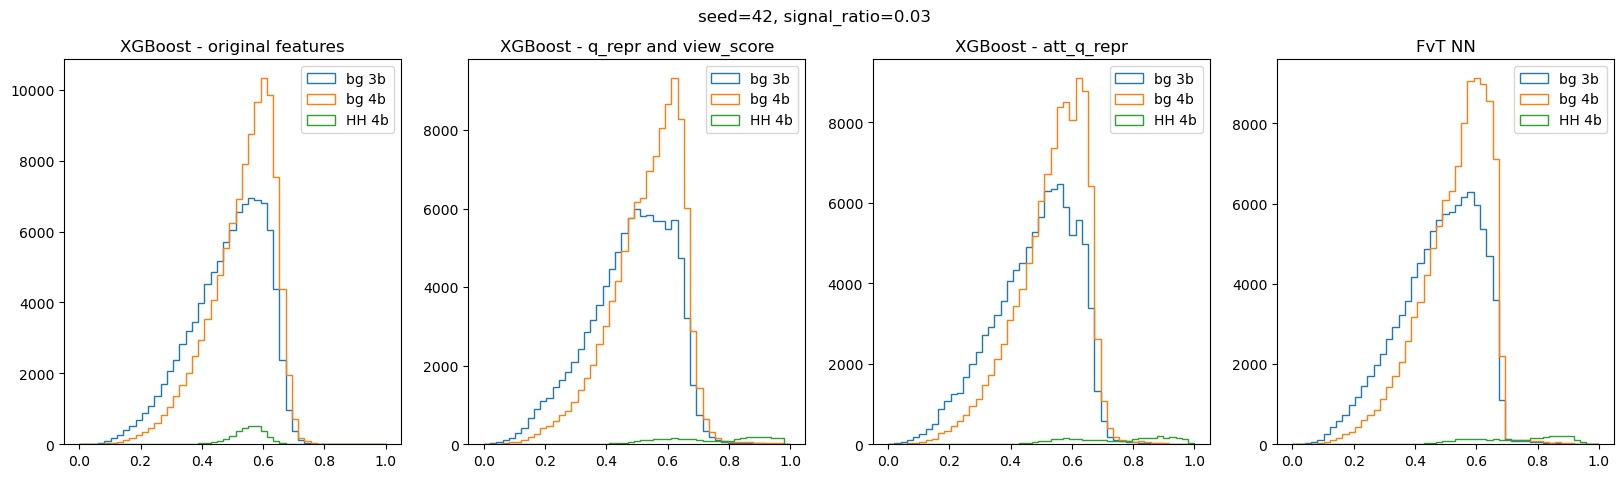

Signal 4b scores
XGBoost - original features:  0.55812657
XGBoost - q_repr and view_score:  0.76434267
XGBoost - att_q_repr:  0.76523894
FvT NN:  0.74771243


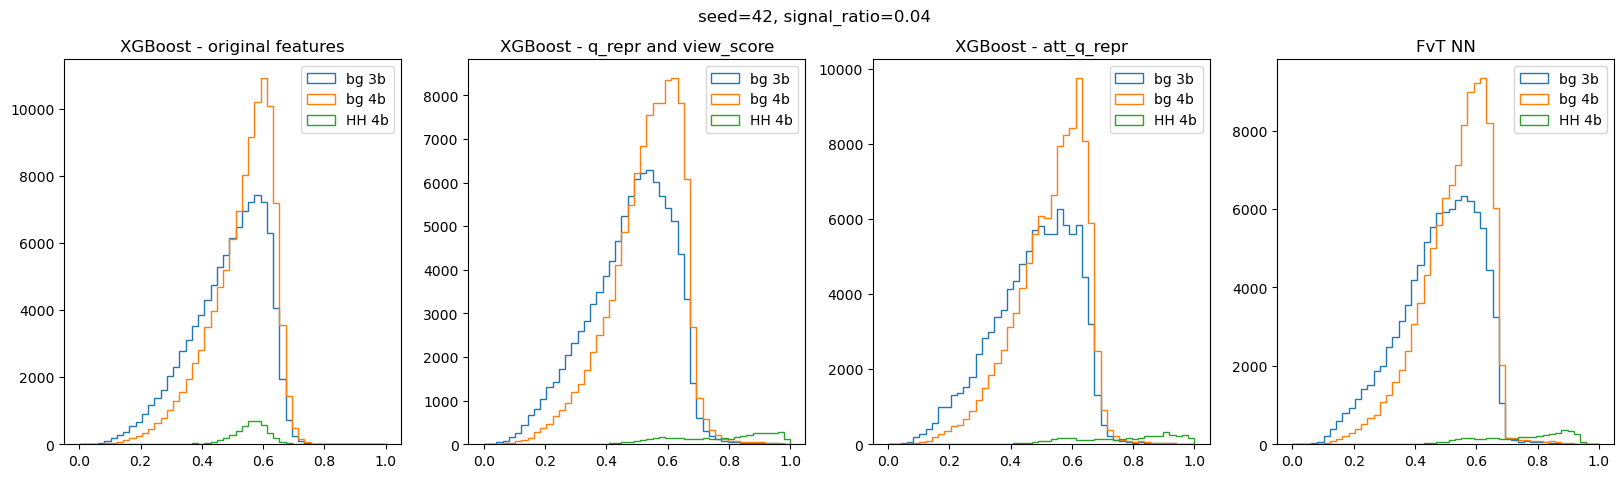

Signal 4b scores
XGBoost - original features:  0.56450975
XGBoost - q_repr and view_score:  0.7822307
XGBoost - att_q_repr:  0.7842574
FvT NN:  0.7704406


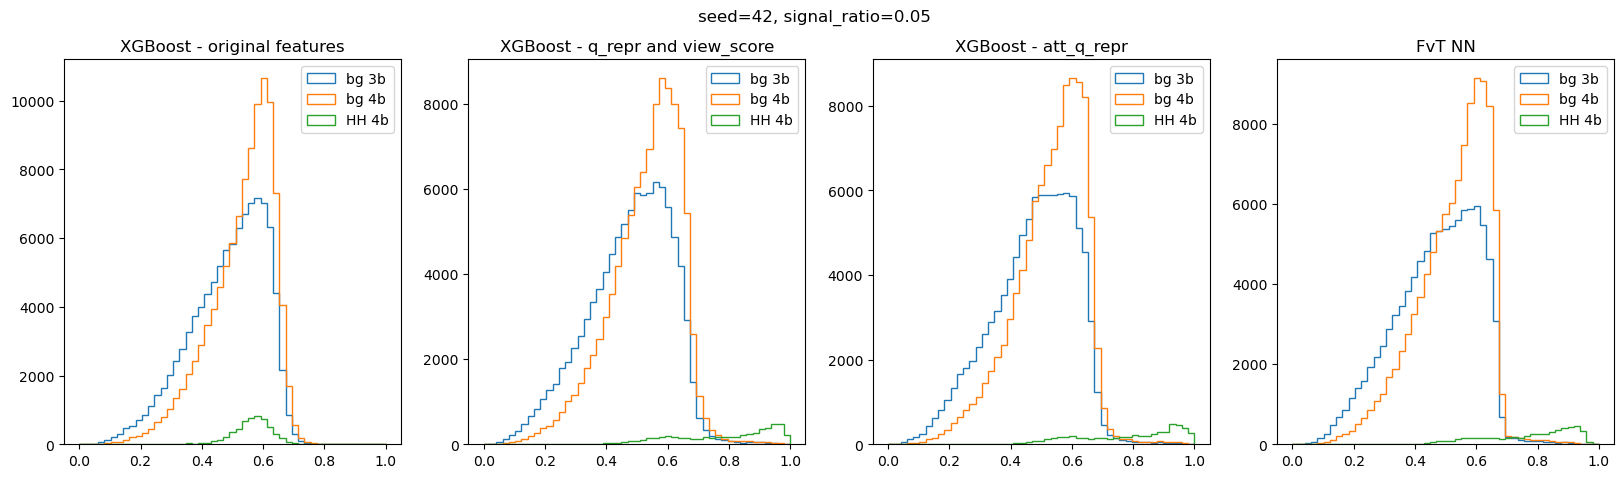

In [40]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

config_filename = "configs/fvt_training_higher_sr.yml"

config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
n_all4b = config["n_all4b"]
signal_ratio = config["signal_ratio"]
test_ratio = config["test_ratio"]
n_sample_ratios = [1.0]
seeds = [42]
w_cuts = np.arange(0.01, 1.01, 0.01)
signal_ratios = [0.01, 0.02, 0.03, 0.04, 0.05]
dim_quadjet_features = config["dim_quadjet_features"]

for seed in seeds:
    for signal_ratio in signal_ratios:
        dinfo_train, dinfo_test = generate_tt_dataset(
                seed,
                n_3b,
                n_all4b,
                signal_ratio,
                test_ratio,
            )
        xgbreg = XGBRegressor(n_estimators=100, max_depth=20, random_state=seed)
        
        events_train = EventsData.from_dataframe(dinfo_train.fetch_data(), features=features)
        events_xgb_train, events_xgb_val = events_train.split(0.67, seed=seed)
        events_test = EventsData.from_dataframe(dinfo_test.fetch_data(), features=features)

        hashes = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed, 
                                    "signal_ratio": signal_ratio, "n_sample_ratio": 1.0})
        hash = hashes[0]
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        
        events_xgb_train.set_model_scores(fvt_model)
        events_xgb_val.set_model_scores(fvt_model)
        events_test.set_model_scores(fvt_model)

        param = {
        "max_depth": best_max_depth,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        }
        num_round = best_n_estimator

        dtrain = xgb.DMatrix(events_xgb_train.X, label=events_xgb_train.is_4b, weight=events_xgb_train.weights)
        dval = xgb.DMatrix(events_xgb_val.X, label=events_xgb_val.is_4b, weight=events_xgb_val.weights)
        dtest = xgb.DMatrix(events_test.X, label=events_test.is_4b, weight=events_test.weights)
        bst_orig = xgb.train(param, dtrain, num_round, evals=[(dval, "eval")], early_stopping_rounds=100, verbose_eval=False)
        probs_4b_estimated_orig = bst_orig.predict(dtest)
        
        X_train = np.concatenate([events_xgb_train.q_repr.reshape(-1, 3 * dim_quadjet_features), events_xgb_train.view_score], axis=1)
        dtrain = xgb.DMatrix(X_train, label=events_xgb_train.is_4b, weight=events_xgb_train.weights)
        X_val = np.concatenate([events_xgb_val.q_repr.reshape(-1, 3 * dim_quadjet_features), events_xgb_val.view_score], axis=1)
        dval = xgb.DMatrix(X_val, label=events_xgb_val.is_4b, weight=events_xgb_val.weights)
        X_test = np.concatenate([events_test.q_repr.reshape(-1, 3 * dim_quadjet_features), events_test.view_score], axis=1)
        dtest = xgb.DMatrix(X_test, label=events_test.is_4b, weight=events_test.weights)
        bst_q_repr = xgb.train(param, dtrain, num_round, evals=[(dval, "eval")], early_stopping_rounds=100, verbose_eval=False)
        probs_4b_estimated_q_repr = bst_q_repr.predict(dtest)
        
        dtrain = xgb.DMatrix(events_xgb_train.att_q_repr, label=events_xgb_train.is_4b, weight=events_xgb_train.weights)
        dval = xgb.DMatrix(events_xgb_val.att_q_repr, label=events_xgb_val.is_4b, weight=events_xgb_val.weights)
        dtest = xgb.DMatrix(events_test.att_q_repr, label=events_test.is_4b, weight=events_test.weights)
        bst_att_q_repr = xgb.train(param, dtrain, num_round, evals=[(dval, "eval")], early_stopping_rounds=100, verbose_eval=False)
        probs_4b_estimated_att_q_repr = bst_att_q_repr.predict(dtest)

        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
        fig.suptitle(f"seed={seed}, signal_ratio={signal_ratio}")
        
        bins_range = np.linspace(0, 1, 50)
        ax[0].set_title("XGBoost - original features")
        ax[0].hist(probs_4b_estimated_orig[events_test.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax[0].hist(probs_4b_estimated_orig[events_test.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax[0].hist(probs_4b_estimated_orig[events_test.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax[0].legend()
        
        ax[1].set_title("XGBoost - q_repr and view_score")
        ax[1].hist(probs_4b_estimated_q_repr[events_test.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax[1].hist(probs_4b_estimated_q_repr[events_test.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax[1].hist(probs_4b_estimated_q_repr[events_test.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax[1].legend()
        
        ax[2].set_title("XGBoost - att_q_repr")
        ax[2].hist(probs_4b_estimated_att_q_repr[events_test.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax[2].hist(probs_4b_estimated_att_q_repr[events_test.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax[2].hist(probs_4b_estimated_att_q_repr[events_test.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax[2].legend()

        ax[3].set_title("FvT NN")
        ax[3].hist(events_test.fvt_score[events_test.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax[3].hist(events_test.fvt_score[events_test.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax[3].hist(events_test.fvt_score[events_test.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax[3].legend()
        
        print("Signal 4b scores")
        print("XGBoost - original features: ", np.mean(probs_4b_estimated_orig[events_test.is_signal]))
        print("XGBoost - q_repr and view_score: ", np.mean(probs_4b_estimated_q_repr[events_test.is_signal]))
        print("XGBoost - att_q_repr: ", np.mean(probs_4b_estimated_att_q_repr[events_test.is_signal]))
        print("FvT NN: ", np.mean(events_test.fvt_score[events_test.is_signal]))

        plt.show()
        plt.close()

        

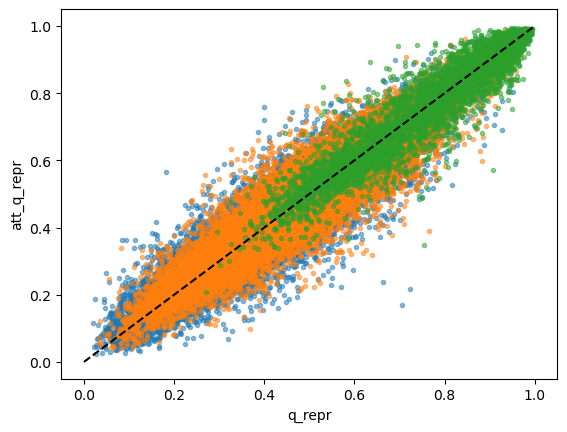

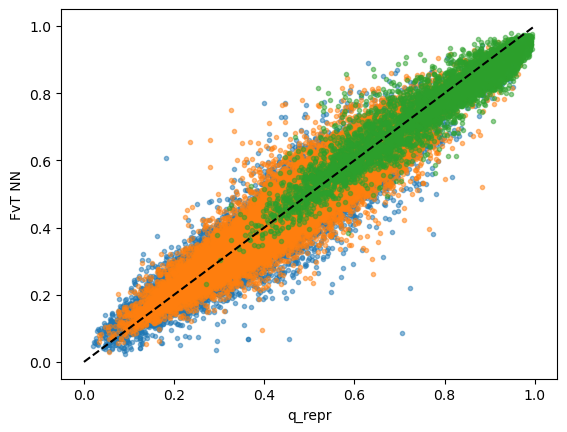

In [35]:
is_3b = events_test.is_3b
is_bg4b = events_test.is_bg4b
is_signal = events_test.is_signal

plt.plot(probs_4b_estimated_q_repr[is_3b], probs_4b_estimated_att_q_repr[is_3b], ".", alpha=0.5)
plt.plot(probs_4b_estimated_q_repr[is_bg4b], probs_4b_estimated_att_q_repr[is_bg4b], ".", alpha=0.5)
plt.plot(probs_4b_estimated_q_repr[is_signal], probs_4b_estimated_att_q_repr[is_signal], ".", alpha=0.5)
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("q_repr")
plt.ylabel("att_q_repr")
plt.show()
plt.close()

plt.plot(probs_4b_estimated_q_repr[is_3b], events_test.fvt_score[is_3b], ".", alpha=0.5)
plt.plot(probs_4b_estimated_q_repr[is_bg4b], events_test.fvt_score[is_bg4b], ".", alpha=0.5)
plt.plot(probs_4b_estimated_q_repr[is_signal], events_test.fvt_score[is_signal], ".", alpha=0.5)
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("q_repr")
plt.ylabel("FvT NN")
plt.show()
plt.close()